# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

EPOCHS_AE = 30#30
PATIENCE_AE = 0#10
LIST_UNITS_AE = [512]
LIST_UNITS_ENC_AE = [32]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 10#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [512]#ROUND 64 = 512
LIST_DROPOUT_PRED = [0.3]#ROUND 64 = 0.5

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_73870/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
99929  1702509900000   2259.44   2264.00  2259.43    2263.28    980.4476   
99930  1702510200000   2263.28   2264.53  2261.96    2263.44    769.0674   
99931  1702510500000   2263.43   2263.44  2259.24    2260.35    642.2866   
99932  1702510800000   2260.36   2260.67  2255.94    2255.95   1183.1841   
99933  1702511100000   2255.94   2257.37  2255.94    2257.36    208.2880   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1768.158184       1767.684879   
1      2023-01-01 00:05:00       1768.158184       1767.684879   
2      2023-01-01 00:10:00       1768.158184       1767.684879   
3      2023-01-01 00:15:00       1768.158184       1767.684879   
4      2023-01-01 00:20:00       1768.158184       1767.684879   
...                    ...               ...               ...   
99929  2023-12-13 23:25:00       2250.710000       2232.585000   
99930  2023-12-13 23:30:00       2250.670000       2232.810000   
99931  2023-12-13 23:35:00       2251.205000       2232.810000   
99932  2023-12-13 23:40:00       2251.205000       2234.405000   
99933  2023-12-13 23:45:00       2251.745000       2234.555000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
99929        2266.745  ...   NaN         NaN            NaN           NaN   
99930        2267.580  ...   NaN         NaN            NaN           NaN   
99931        2267.580  ...   NaN         NaN            NaN           NaN   
99932        2267.580  ...   NaN         NaN            NaN           NaN   
99933        2268.080  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
99929               NaN         0.0               NaN         0.0      0.0   
99930               NaN         0.0               NaN         0.0      0.0   
99931               NaN         0.0               NaN         0.0      0.0   
99932               NaN         0.0               NaN         0.0      0.0   
99933               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
99929   NaN  
99930   NaN  
99931   NaN  
99932   NaN  
99933   NaN  

[99934 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              99889
Event               99889
Country             99889
keep                99889
date                99889
Length: 65, dtype: int64

on 99934 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
99929  1702509900000   2259.44   2264.00  2259.43    2263.28    980.4476   
99930  1702510200000   2263.28   2264.53  2261.96    2263.44    769.0674   
99931  1702510500000   2263.43   2263.44  2259.24    2260.35    642.2866   
99932  1702510800000   2260.36   2260.67  2255.94    2255.95   1183.1841   
99933  1702511100000   2255.94   2257.37  2255.94    2257.36    208.2880   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1768.158184       1767.684879   
1      2023-01-01 00:05:00       1768.158184       1767.684879   
2      2023-01-01 00:10:00       1768.158184       1767.684879   
3      2023-01-01 00:15:00       1768.158184       1767.684879   
4      2023-01-01 00:20:00       1768.158184       1767.684879   
...                    ...               ...               ...   
99929  2023-12-13 23:25:00       2250.710000       2232.585000   
99930  2023-12-13 23:30:00       2250.670000       2232.810000   
99931  2023-12-13 23:35:00       2251.205000       2232.810000   
99932  2023-12-13 23:40:00       2251.205000       2234.405000   
99933  2023-12-13 23:45:00       2251.745000       2234.555000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
99929        2266.745  ...   NaN         NaN            NaN           NaN   
99930        2267.580  ...   NaN         NaN            NaN           NaN   
99931        2267.580  ...   NaN         NaN            NaN           NaN   
99932        2267.580  ...   NaN         NaN            NaN           NaN   
99933        2268.080  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
99929               NaN         0.0               NaN         0.0      0.0   
99930               NaN         0.0               NaN         0.0      0.0   
99931               NaN         0.0               NaN         0.0      0.0   
99932               NaN         0.0               NaN         0.0      0.0   
99933               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
99929                  NaN  
99930                  NaN  
99931                  NaN  
99932                  NaN  
99933                  NaN  

[99934 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       57
delta_event_real    57
delta_event_pred    57
Previous_num        57
Actual_num          57
Event               57
Date                57
Previous            57
Consensus           57
Actual              57
Country             57
Time (ET)           57
keep                57
date                57
dtype: int64

on 99934 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
99929   2259.44   2264.00  2259.43    2263.28    980.4476   
99930   2263.28   2264.53  2261.96    2263.44    769.0674   
99931   2263.43   2263.44  2259.24    2260.35    642.2866   
99932   2260.36   2260.67  2255.94    2255.95   1183.1841   
99933   2255.94   2257.37  2255.94    2257.36    208.2880   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1768.158184       1767.684879   
1      2023-01-01 00:05:00       1768.158184       1767.684879   
2      2023-01-01 00:10:00       1768.158184       1767.684879   
3      2023-01-01 00:15:00       1768.158184       1767.684879   
4      2023-01-01 00:20:00       1768.158184       1767.684879   
...                    ...               ...               ...   
99929  2023-12-13 23:25:00       2250.710000       2232.585000   
99930  2023-12-13 23:30:00       2250.670000       2232.810000   
99931  2023-12-13 23:35:00       2251.205000       2232.810000   
99932  2023-12-13 23:40:00       2251.205000       2234.405000   
99933  2023-12-13 23:45:00       2251.745000       2234.555000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710          1194.71  ...  1196.096667  1196.096667   
1            1194.710          1194.71  ...  1195.801420  1195.801420   
2            1194.710          1194.71  ...  1195.648641  1195.648641   
3            1194.710          1194.71  ...  1195.575250  1195.575250   
4            1194.710          1194.71  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
99929        2266.745          2260.40  ...  2200.675843  2019.513642   
99930        2267.580          2260.40  ...  2200.687218  2019.536156   
99931        2267.580          2260.40  ...  2200.696929  2019.570325   
99932        2267.580          2260.40  ...  2200.715509  2019.597369   
99933        2268.080          2260.40  ...  2200.722464  2019.617940   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
99929  1873.939841  2122.244207   1765.601626          2.550867  0.219893   
99930  1873.952303  2122.261263   1765.604585          2.551602  0.219946   
99931  1873.960705  2122.280159   1765.607045          2.535684  0.218879   
99932  1873.975654  2122.306684   1765.611545          2.513044  0.217353   
99933  1873.980914  2122.316279   1765.612336          2.520200  0.217842   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.204458e+08      508194.0       17.993903  
1      1.204458e+08      508194.0       17.993903  
2      1.204458e+08      508194.0       17.993903  
3      1.204458e+08      508194.0       17.993903  
4      1.204458e+08      508194.0       17.993903  
...             ...           ...             ...  
99929  1.202118e+08      460873.0       16.320421  
99930  1.202118e+08      460873.0       16.320421  
99931  1.202118e+08      460873.0       16.320421  
99932  1.202118e+08      460873.0       16.320421  
99933  1.202118e+08      460873.0       16.320421  

[99934 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
99929  4.003  4707.089844  102.905998
99930  4.003  4707.089844  102.905998
99931  4.003  4707.089844  102.905998
99932  4.003  4707.089844  102.905998
99933  4.003  4707.089844  102.905998

[99934 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

99934

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

99434

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
99929  1702509900000   2259.44   2264.00  2259.43    2263.28    980.4476   
99930  1702510200000   2263.28   2264.53  2261.96    2263.44    769.0674   
99931  1702510500000   2263.43   2263.44  2259.24    2260.35    642.2866   
99932  1702510800000   2260.36   2260.67  2255.94    2255.95   1183.1841   
99933  1702511100000   2255.94   2257.37  2255.94    2257.36    208.2880   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1768.158184       1767.684879   
1      2023-01-01 00:05:00       1768.158184       1767.684879   
2      2023-01-01 00:10:00       1768.158184       1767.684879   
3      2023-01-01 00:15:00       1768.158184       1767.684879   
4      2023-01-01 00:20:00       1768.158184       1767.684879   
...                    ...               ...               ...   
99929  2023-12-13 23:25:00       2250.710000       2232.585000   
99930  2023-12-13 23:30:00       2250.670000       2232.810000   
99931  2023-12-13 23:35:00       2251.205000       2232.810000   
99932  2023-12-13 23:40:00       2251.205000       2234.405000   
99933  2023-12-13 23:45:00       2251.745000       2234.555000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
99929        2266.745  ...         NaN            NaN           NaN   
99930        2267.580  ...         NaN            NaN           NaN   
99931        2267.580  ...         NaN            NaN           NaN   
99932        2267.580  ...         NaN            NaN           NaN   
99933        2268.080  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
99929               NaN         0.0               NaN         0.0      0.0   
99930               NaN         0.0               NaN         0.0      0.0   
99931               NaN         0.0               NaN         0.0      0.0   
99932               NaN         0.0               NaN         0.0      0.0   
99933               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
99929                  NaN  False  
99930                  NaN  False  
99931                  NaN  False  
99932                  NaN  False  
99933                  NaN  False  

[99934 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
99430  1702360200000   2224.71   2225.95  2223.26    2224.00   1011.7285   
99431  1702360500000   2224.00   2227.56  2223.56    2225.60    800.7846   
99432  1702360800000   2225.59   2226.59  2224.00    2224.78   1314.2009   
99433  1702361100000   2224.78   2224.79  2220.73    2220.85   1917.4042   
99434  1702361400000   2220.86   2223.87  2220.85    2222.01   1228.3838   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1768.158184       1767.684879   
1      2023-01-01 00:05:00       1768.158184       1767.684879   
2      2023-01-01 00:10:00       1768.158184       1767.684879   
3      2023-01-01 00:15:00       1768.158184       1767.684879   
4      2023-01-01 00:20:00       1768.158184       1767.684879   
...                    ...               ...               ...   
99430  2023-12-12 05:50:00       2237.290000       2231.135000   
99431  2023-12-12 05:55:00       2236.830000       2232.580000   
99432  2023-12-12 06:00:00       2236.695000       2232.580000   
99433  2023-12-12 06:05:00       2235.920000       2232.655000   
99434  2023-12-12 06:10:00       2235.885000       2232.655000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
99430         2225.82  ...         4.0            4.0           4.0   
99431         2225.82  ...         4.0            4.0           4.0   
99432         2225.82  ...         4.0            4.0           4.0   
99433         2225.82  ...         4.0            4.0           4.0   
99434         2225.82  ...         4.0            4.0           4.0   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
99430               0.0         0.0               0.0         0.0      0.0   
99431               0.0         0.0               0.0         0.0      0.0   
99432               0.0         0.0               0.0         0.0      0.0   
99433               0.0         0.0               0.0         0.0      0.0   
99434               0.0         0.0               0.0         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
99430  2023-12-12 13:00:00   True  
99431  2023-12-12 13:00:00   True  
99432  2023-12-12 13:00:00   True  
99433  2023-12-12 13:00:00   True  
99434  2023-12-12 13:00:00   True  

[99435 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
99435  1702361700000   2222.02   2222.07  2219.16    2220.74    900.6474   
99436  1702362000000   2220.74   2221.20  2215.99    2217.01   2117.3656   
99437  1702362300000   2217.01   2217.66  2211.91    2213.27   1880.2416   
99438  1702362600000   2213.27   2220.31  2212.44    2219.35   1086.9689   
99439  1702362900000   2219.36   2220.00  2216.23    2217.78    835.6561   
...              ...       ...       ...      ...        ...         ...   
99929  1702509900000   2259.44   2264.00  2259.43    2263.28    980.4476   
99930  1702510200000   2263.28   2264.53  2261.96    2263.44    769.0674   
99931  1702510500000   2263.43   2263.44  2259.24    2260.35    642.2866   
99932  1702510800000   2260.36   2260.67  2255.94    2255.95   1183.1841   
99933  1702511100000   2255.94   2257.37  2255.94    2257.36    208.2880   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
99435  2023-12-12 06:15:00          2235.885          2232.655   
99436  2023-12-12 06:20:00          2235.885          2232.655   
99437  2023-12-12 06:25:00          2235.250          2232.655   
99438  2023-12-12 06:30:00          2234.600          2232.655   
99439  2023-12-12 06:35:00          2234.430          2232.655   
...                    ...               ...               ...   
99929  2023-12-13 23:25:00          2250.710          2232.585   
99930  2023-12-13 23:30:00          2250.670          2232.810   
99931  2023-12-13 23:35:00          2251.205          2232.810   
99932  2023-12-13 23:40:00          2251.205          2234.405   
99933  2023-12-13 23:45:00          2251.745          2234.555   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
99435        2225.820  ...         4.0            4.0           4.0   
99436        2224.485  ...         4.0            4.0           4.0   
99437        2222.190  ...         4.0            4.0           4.0   
99438        2221.665  ...         4.0            4.0           4.0   
99439        2221.665  ...         4.0            4.0           4.0   
...               ...  ...         ...            ...           ...   
99929        2266.745  ...         NaN            NaN           NaN   
99930        2267.580  ...         NaN            NaN           NaN   
99931        2267.580  ...         NaN            NaN           NaN   
99932        2267.580  ...         NaN            NaN           NaN   
99933        2268.080  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
99435               0.0         0.0               0.0         0.0      0.0   
99436               0.0         0.0               0.0         0.0      0.0   
99437               0.0         0.0               0.0         0.0      0.0   
99438               0.0         0.0               0.0         0.0      0.0   
99439               0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
99929               NaN         0.0               NaN         0.0      0.0   
99930               NaN         0.0               NaN         0.0      0.0   
99931               NaN         0.0               NaN         0.0      0.0   
99932               NaN         0.0               NaN         0.0      0.0   
99933               NaN         0.0               NaN         0.0      0.0   

                      date  train  
99435  2023-12-12 13:00:00  False  
99436  2023-12-12 13:00:00  False  
99437  2023-12-12 13:00:00  False  
99438  2023-12-12 13:00:00  False  
99439  2023-12-12 13:00:00  False  
...                    ...    ...  
99929                  NaN  False  
99930                  NaN  False  
99931                  NaN  False  
99932                  NaN  False  
99933                  NaN  False  

[499 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(99348, 72, 102) (99348, 15)
(412, 72, 102) (412, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99705413, 0.99897906, 0.99980211, 1.00047674, 1.00252311,
       1.00207785, 1.00347658, 1.00225326, 1.00204637, 1.001808  ,
       1.00056669, 1.00024736, 1.00096697, 1.00059817, 0.99883065])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00101639, 0.99995503, 0.99700929, ..., 1.00052169, 1.00020238,
        1.00092195],
       [0.99893971, 0.99599696, 0.99791986, ..., 0.99918681, 0.99990565,
        0.99953725],
       [0.99705413, 0.99897906, 0.99980211, ..., 1.00096697, 1.00059817,
        0.99883065]])

In [39]:
seq_y

array([0.99705413, 0.99897906, 0.99980211, 1.00047674, 1.00252311,
       1.00207785, 1.00347658, 1.00225326, 1.00204637, 1.001808  ,
       1.00056669, 1.00024736, 1.00096697, 1.00059817, 0.99883065])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00101639, 0.99995503, 0.99700929, ..., 1.00052169, 1.00020238,
        1.00092195],
       [0.99893971, 0.99599696, 0.99791986, ..., 0.99918681, 0.99990565,
        0.99953725],
       [0.99705413, 0.99897906, 0.99980211, ..., 1.00096697, 1.00059817,
        0.99883065]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(99348, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(99348, 72, 102) (99348, 15)
(412, 72, 102) (412, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00101639, 0.99995503, 0.99700929, ..., 1.00052169, 1.00020238,
        1.00092195],
       [0.99893971, 0.99599696, 0.99791986, ..., 0.99918681, 0.99990565,
        0.99953725],
       [0.99705413, 0.99897906, 0.99980211, ..., 1.00096697, 1.00059817,
        0.99883065]])

In [47]:
np.mean(y_train_sca)

-0.00022036743478534606

In [48]:
np.std(y_train_sca)

1.0002490022575101

In [49]:
np.mean(y_test_sca)

0.08208688586531748

In [50]:
np.std(y_test_sca)

1.1693096103475407

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1768.158184       1767.684879   
1    1195.38   1196.31   1196.69  1194.90       1768.158184       1767.684879   
2    1194.55   1195.38   1195.81  1194.55       1768.158184       1767.684879   
3    1195.98   1194.55   1195.98  1194.31       1768.158184       1767.684879   
4    1196.06   1195.98   1196.37  1195.97       1768.158184       1767.684879   
5    1196.61   1196.06   1196.70  1196.06       1768.158184       1767.684879   
6    1194.36   1196.62   1196.62  1193.72       1768.158184       1767.684879   
7    1194.22   1194.37   1194.43  1192.72       1768.158184       1767.684879   
8    1193.64   1194.22   1194.22  1193.02       1768.158184       1767.684879   
9    1194.64   1193.64   1195.06  1193.63       1768.158184       1767.684879   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1769.468306   
1         1194.71          1194.71           1769.468306   
2         1194.71          1194.71           1769.468306   
3         1194.71          1194.71           1769.468306   
4         1194.71          1194.71           1769.468306   
5         1194.71          1194.71           1769.468306   
6         1194.71          1194.71           1769.468306   
7         1194.71          1194.71           1769.468306   
8         1194.71          1194.71           1769.468306   
9         1194.71          1194.71           1769.468306   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
1           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
2           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
3           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
4           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
5           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
6           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
7           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
8           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   
9           1761.853909  ...  1.204458e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(7153056, 102)

In [57]:
X_train[:,-1,:].shape

(99348, 102)

In [58]:
X_test[:,-1,:].shape

(412, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0        0.02306 -0.002473 -0.056736  0.091855         -0.031998   
1        0.02306 -0.030288 -0.068766  0.063949         -0.065035   
2        0.02306  0.033317 -0.046720  0.099842         -0.058607   
3        0.02306  0.114886  0.022492  0.106813          0.010554   
4        0.02306 -0.056140 -0.066761  0.039009         -0.031441   
...          ...       ...       ...       ...               ...   
99755    0.02306 -0.025847  0.029493  0.010557         -1.146488   
99756    0.02306 -0.456457  0.246794 -0.414951         -1.458412   
99757    0.02306 -0.080842  0.183469 -0.120661         -1.389426   
99758    0.02306  0.114641  0.220994 -0.009922         -1.304971   
99759    0.02306  0.243860  0.334788  0.052217         -1.082959   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.029326       -0.136008        -0.029008   
1             -0.007912       -0.167206        -0.061813   
2             -0.001820       -0.152748        -0.027513   
3              0.059819       -0.067854         0.061707   
4              0.005626       -0.142493        -0.016736   
...                 ...             ...              ...   
99755         -1.367473       -0.475244        -0.353341   
99756         -1.688376       -0.596888        -0.481660   
99757         -1.622754       -0.674664        -0.563436   
99758         -1.562197       -0.589955        -0.448684   
99759         -1.414945       -0.336108        -0.225177   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  9.408814              8.748529  ...  0.365908  1.365101   
1                  9.395550              8.736143  ... -0.000165  1.413283   
2                  9.397719              8.738169  ... -0.000165  1.413283   
3                  9.419676              8.758671  ... -0.000165  1.413283   
4                  9.400372              8.740645  ... -0.000165  1.413283   
...                     ...                   ...  ...       ...       ...   
99755              0.006401              0.195021  ...  1.224739 -0.707761   
99756             -0.074746              0.120927  ...  1.224739 -0.707761   
99757             -0.091716              0.104881  ...  1.224739 -0.707761   
99758             -0.076954              0.118839  ...  1.224739 -0.707761   
99759             -0.041059              0.152781  ...  1.224739 -0.707761   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.877878    -1.103111          1.377469          0.251765 -0.052741   
1         0.877878    -1.103111          1.377469          0.251765 -0.052741   
2         0.877878    -1.103111          1.377469          0.251765 -0.052741   
3         0.877878    -1.103111          1.377469          0.251765 -0.052741   
4         0.877878    -1.103111          1.377469          0.251765 -0.052741   
...            ...          ...               ...               ...       ...   
99755    -0.318303     1.381887         -1.255794          0.651910 -0.052741   
99756    -0.318303     1.381887         -1.255794          0.651910 -0.052741   
99757    -0.318303     1.381887         -1.255794          0.651910 -0.052741   
99758    -0.318303     1.381887         -1.255794          0.651910 -0.052741   
99759    -0.318303     1.381887         -1.255794          0.651910 -0.052741   

       event_pred  event_real  TRAIN  
0       -0.002186   -0.000729    1.0  
1       -0.002186   -0.000729    1.0  
2       -0.002186   -0.000729    1.0  
3       -0.002186   -0.000729    1.0  
4       -0.002186   -0.000729    1.0  
...           ...         ...    ...  
99755   -0.002186   -0.000729    0.0  
99756   -0.002186   -0.000729    0.0  
99757   -0.002186   -0.000729    0.0  
99758   -0.002186   -0.000729    0.0  
99759   -0.002186   -0.000729    0.0  

[99760 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  9.934800e+04  99348.000000  99348.000000  99348.000000   
mean   2.305979e-02      0.022762      0.023139      0.022597   
std    1.556402e-14      0.172934      0.135168      0.133425   
min    2.305979e-02     -5.732043     -0.069768     -5.676225   
25%    2.305979e-02     -0.043118     -0.052914     -0.006822   
50%    2.305979e-02      0.023378     -0.013894      0.060537   
75%    2.305979e-02      0.087113      0.052112      0.100572   
max    2.305979e-02     11.195500     11.431653      0.118788   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      99348.000000      99348.000000    99348.000000     99348.000000   
mean           0.014260          0.013433        0.021128         0.022356   
std            0.639926          0.690480        0.367443         0.235913   
min           -5.919671         -6.106469       -4.732793        -3.951111   
25%           -0.210470         -0.234527       -0.134434        -0.079535   
50%            0.025863          0.030790        0.032803         0.027026   
75%            0.256605          0.295521        0.191140         0.130966   
max            9.926488         10.154246        6.611184         6.178011   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          99348.000000          99348.000000  ...  99348.000000   
mean               0.003314              0.002233  ...     -0.000213   
std                0.974462              0.977479  ...      1.000186   
min               -3.606627             -3.064966  ...     -1.414563   
25%               -0.404698             -0.452918  ...     -1.000296   
50%                0.019880             -0.002433  ...     -0.000165   
75%                0.331950              0.426696  ...      0.999965   
max                9.438280              8.776044  ...      1.414232   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  99348.000000  99348.000000  99348.000000      99348.000000   
mean      -0.000910      0.002869      0.001058         -0.002808   
std        0.999824      1.000906      0.999090          0.999690   
min       -1.414776     -1.277565     -1.376253         -1.434273   
25%       -1.000616     -1.277565     -1.103111         -0.964303   
50%       -0.000746     -0.318303      0.002817         -0.085807   
75%        0.999124      0.877878      1.108745          0.964751   
max        1.413283      1.410229      1.381887          1.406545   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      99348.000000  99348.000000  99348.000000  99348.000000  99348.0  
mean           0.002479     -0.000112     -0.000005     -0.000002      1.0  
std            1.000267      0.998945      0.998943      0.998943      0.0  
min           -1.440799     -0.052741    -72.236262    -72.234651      1.0  
25%           -1.053047     -0.052741     -0.002186     -0.000729      1.0  
50%           -0.031854     -0.052741     -0.002186     -0.000729      1.0  
75%            1.015197     -0.052741     -0.002186     -0.000729      1.0  
max            1.377092     18.960437     72.231890     72.233194      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  4.120000e+02  412.000000  412.000000  412.000000        412.000000   
mean   2.305979e-02    0.015449    0.063574   -0.028946         -0.111526   
std    3.473665e-18    0.203562    0.123656    0.144919          0.744758   
min    2.305979e-02   -1.020169   -0.069768   -0.928187         -1.690804   
25%    2.305979e-02   -0.088386   -0.031093   -0.078756         -0.562815   
50%    2.305979e-02    0.030117    0.033884    0.014754         -0.144478   
75%    2.305979e-02    0.137491    0.129600    0.065080          0.260800   
max    2.305979e-02    0.743476    0.657085    0.118788          1.677959   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        412.000000      412.000000       412.000000   
mean          -0.107157       -0.116881        -0.037544   
std            0.803590        0.467096         0.304554   
min           -1.848890       -1.088358        -0.860866   
25%           -0.667177       -0.475881        -0.233138   
50%           -0.147233       -0.147703        -0.033880   
75%            0.508637        0.209039         0.176870   
max            1.710021        1.087668         0.759451   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            412.000000            412.000000  ...  412.000000   
mean               1.100193              0.929457  ...   -0.092126   
std                0.489257              0.282163  ...    0.978139   
min               -0.091716              0.104881  ...   -1.414563   
25%                0.820746              0.807075  ...   -1.000296   
50%                1.195361              0.976508  ...   -0.000165   
75%                1.504558              1.121953  ...    0.707033   
max                1.892450              1.445838  ...    1.414232   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  412.000000   412.000000   412.000000        412.000000   
mean    -0.292624     0.093973     1.287746         -1.199207   
std      0.976839     0.569185     0.129970          0.078124   
min     -1.414776    -0.318303     1.108745         -1.255794   
25%     -1.225332    -0.318303     1.108745         -1.255794   
50%     -0.707761    -0.318303     1.381887         -1.255794   
75%      0.706269     0.877878     1.381887         -1.091611   
max      1.413283     0.877878     1.381887         -1.091611   

       day_in_month_sin       day_off  event_pred  event_real  TRAIN  
count        412.000000  4.120000e+02  412.000000  412.000000  412.0  
mean           0.732555 -5.274140e-02    0.173140    0.174596    0.0  
std            0.111338  1.042100e-16    3.558718    3.558710    0.0  
min            0.651910 -5.274140e-02   -0.002186   -0.000729    0.0  
25%            0.651910 -5.274140e-02   -0.002186   -0.000729    0.0  
50%            0.651910 -5.274140e-02   -0.002186   -0.000729    0.0  
75%            0.885895 -5.274140e-02   -0.002186   -0.000729    0.0  
max            0.885895 -5.274140e-02   72.231890   72.233194    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

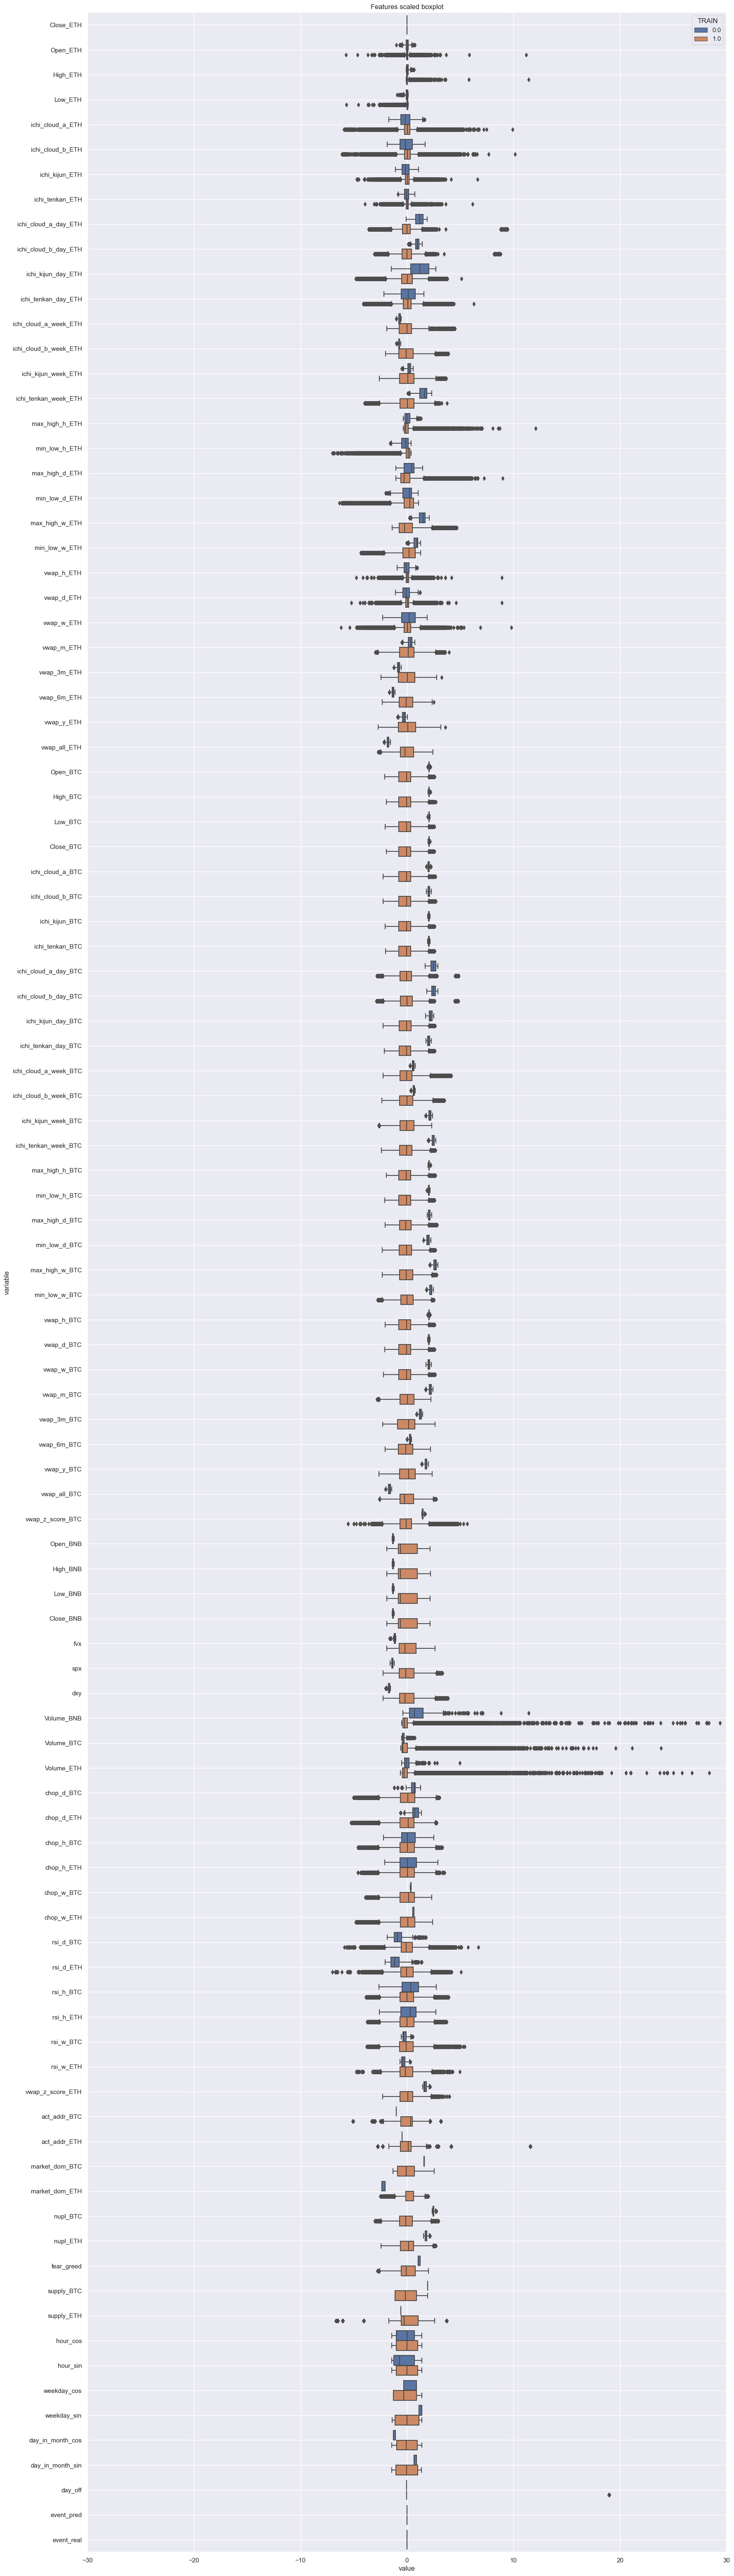

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<Axes: >

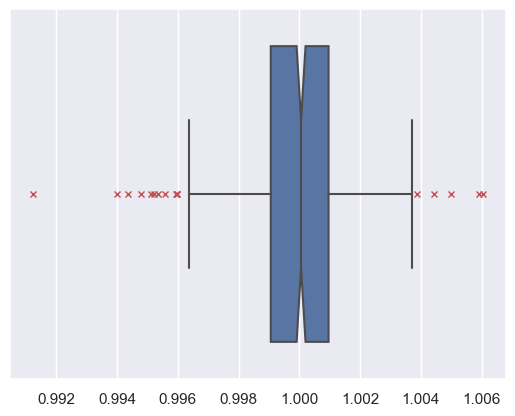

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


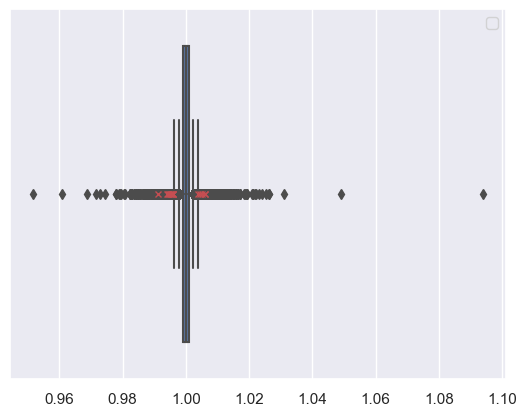

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

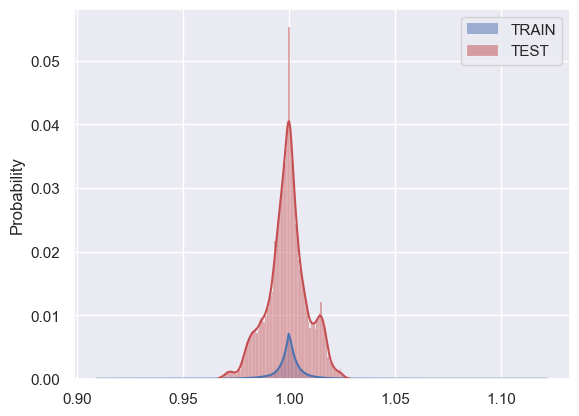

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(99348, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(99348, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10101638],
       [-0.0337505 ],
       [-0.2063667 ],
       ...,
       [ 0.24087171],
       [-0.28152662],
       [-0.75585374]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(99348, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

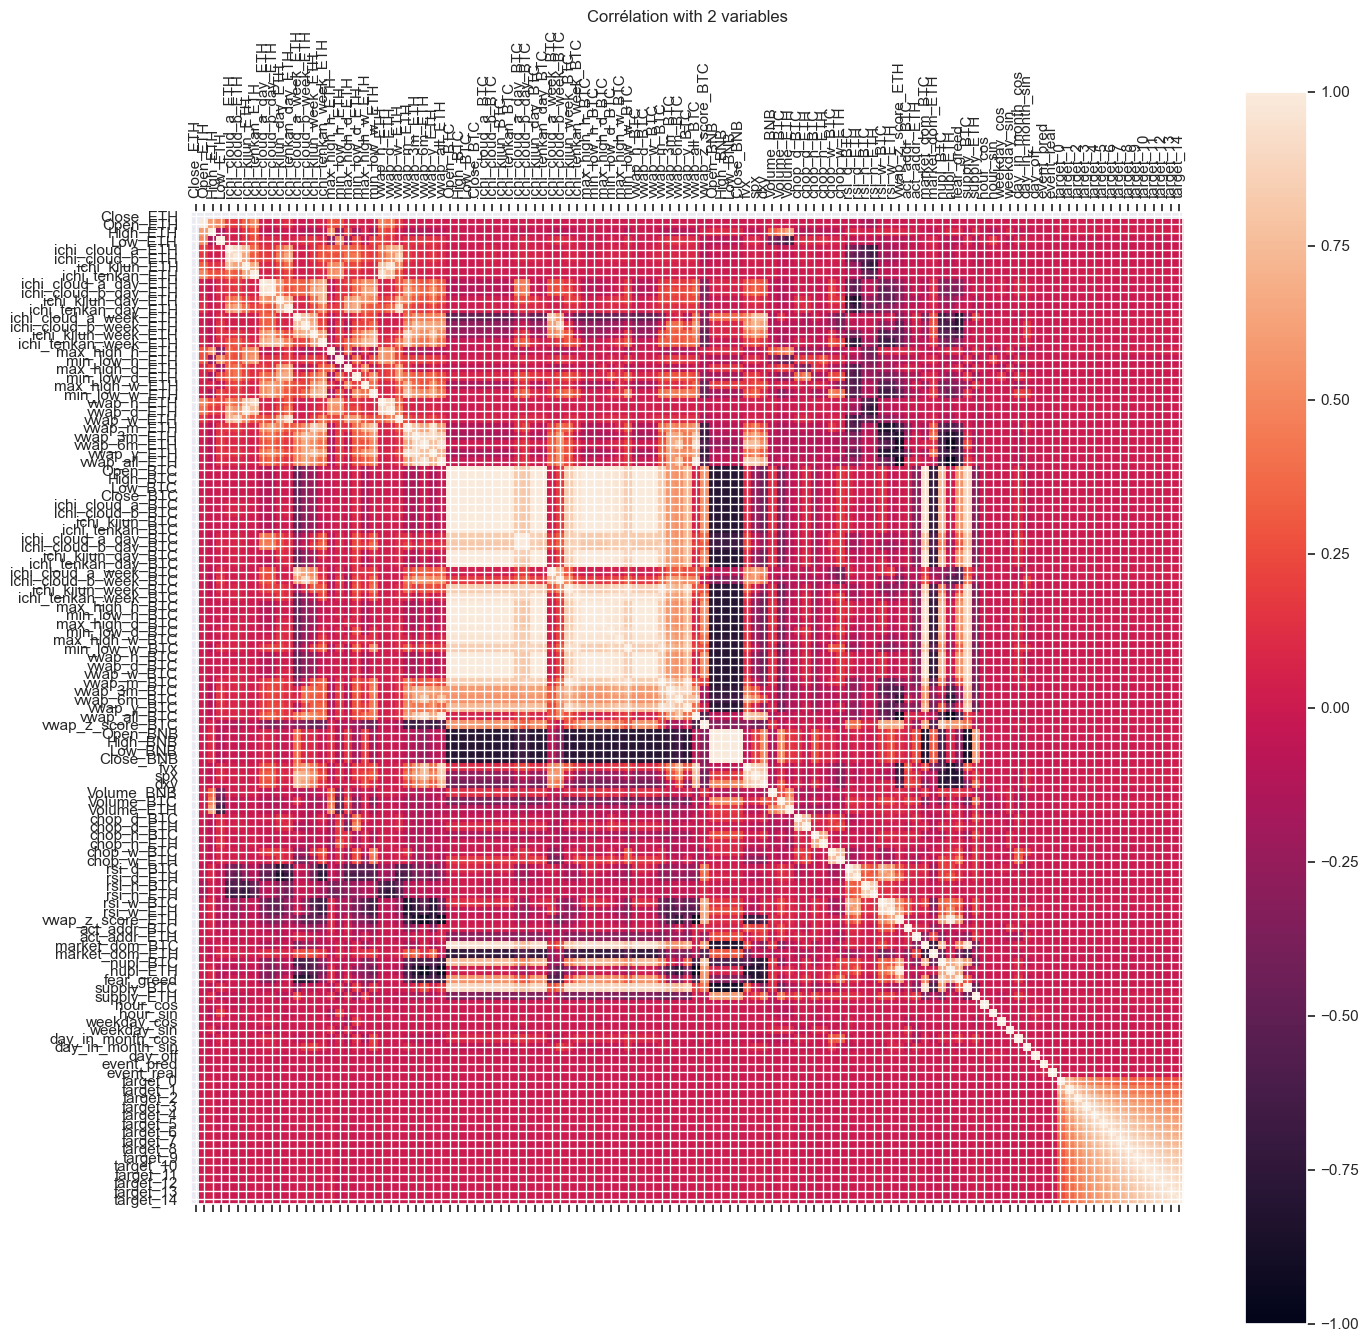

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


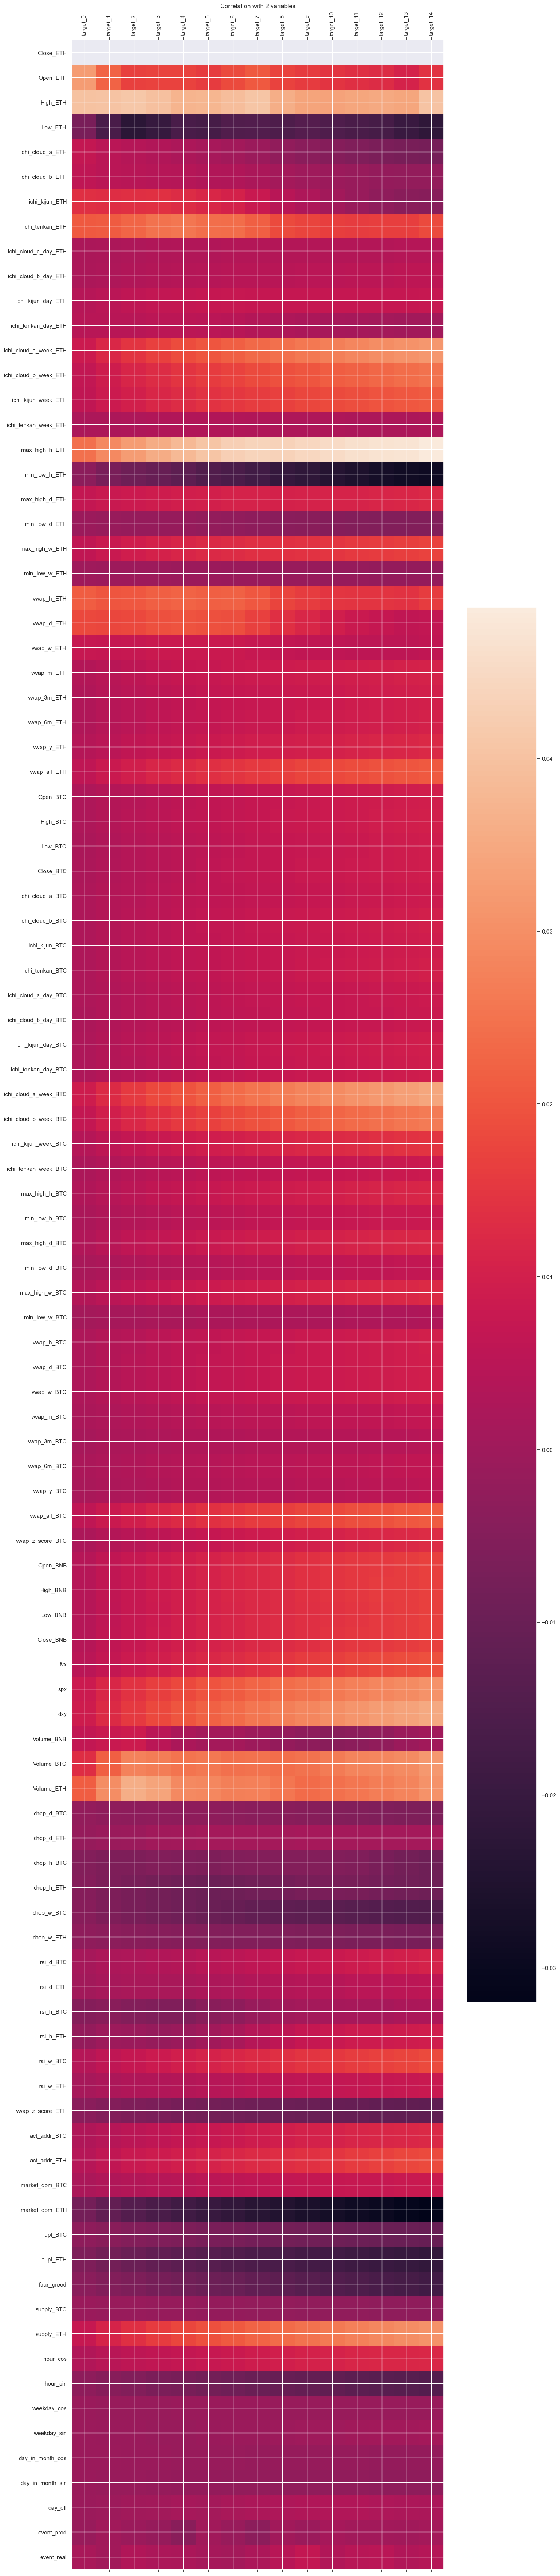

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


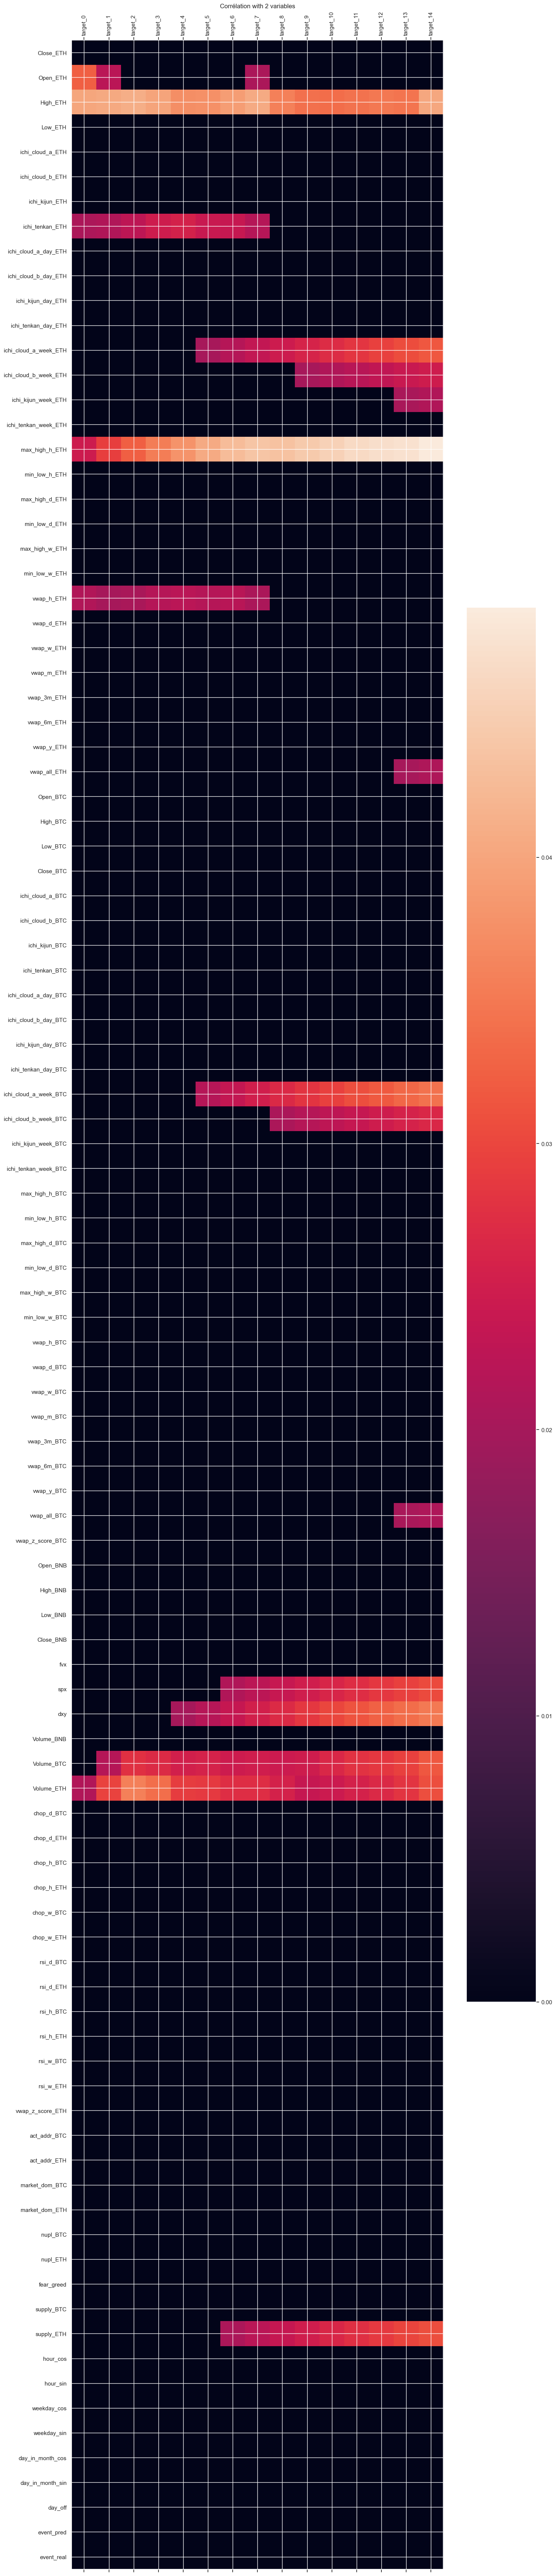

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

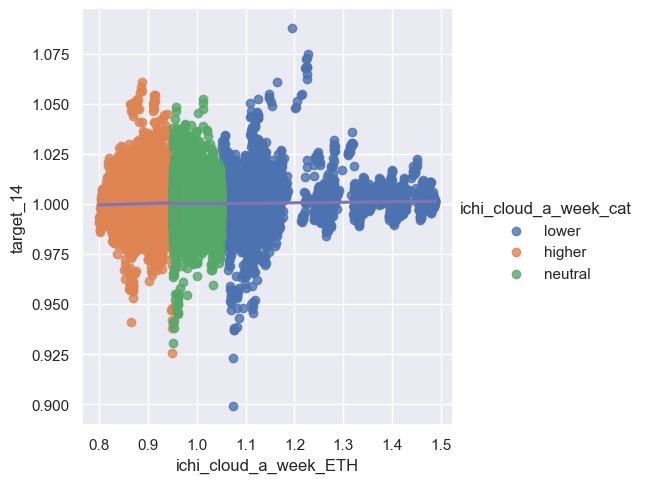

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

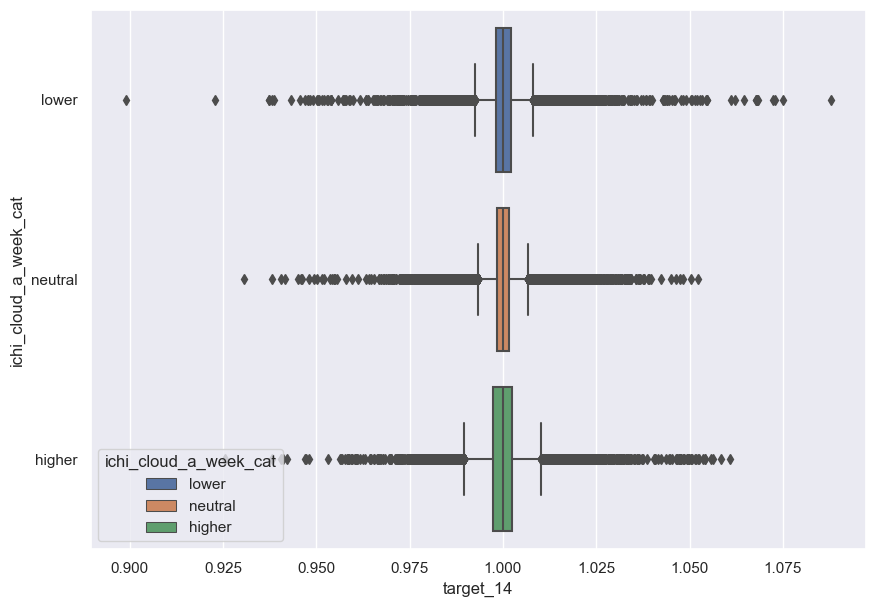

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


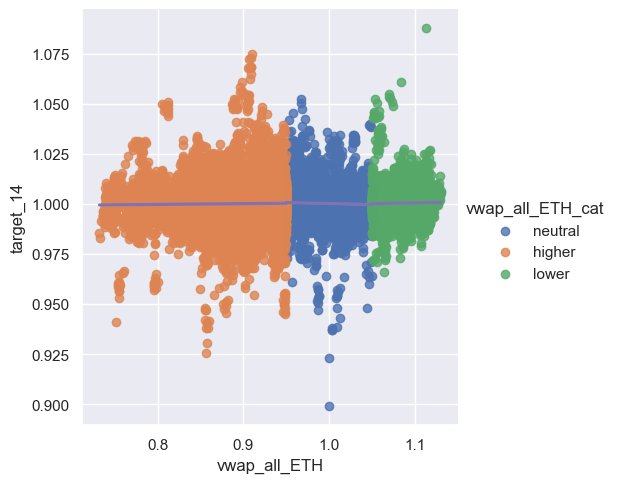

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

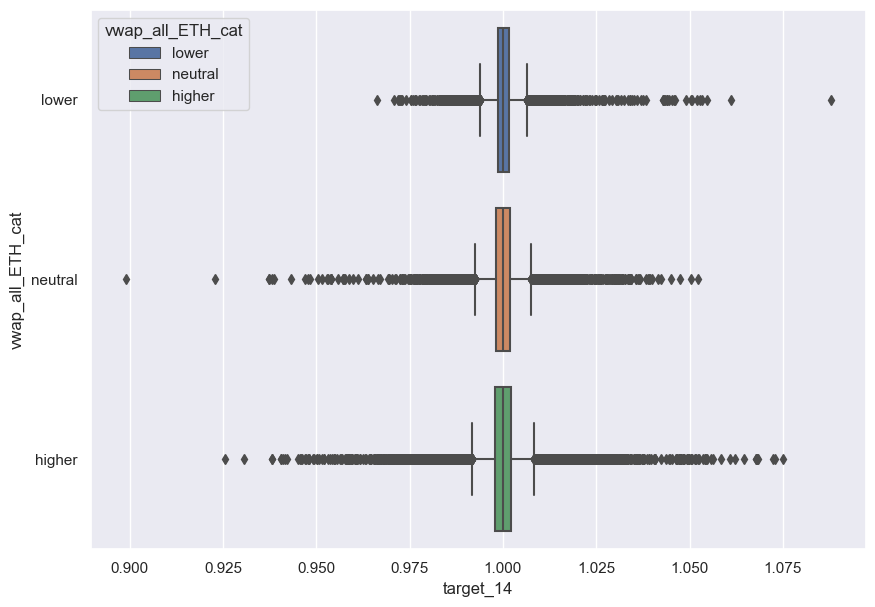

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

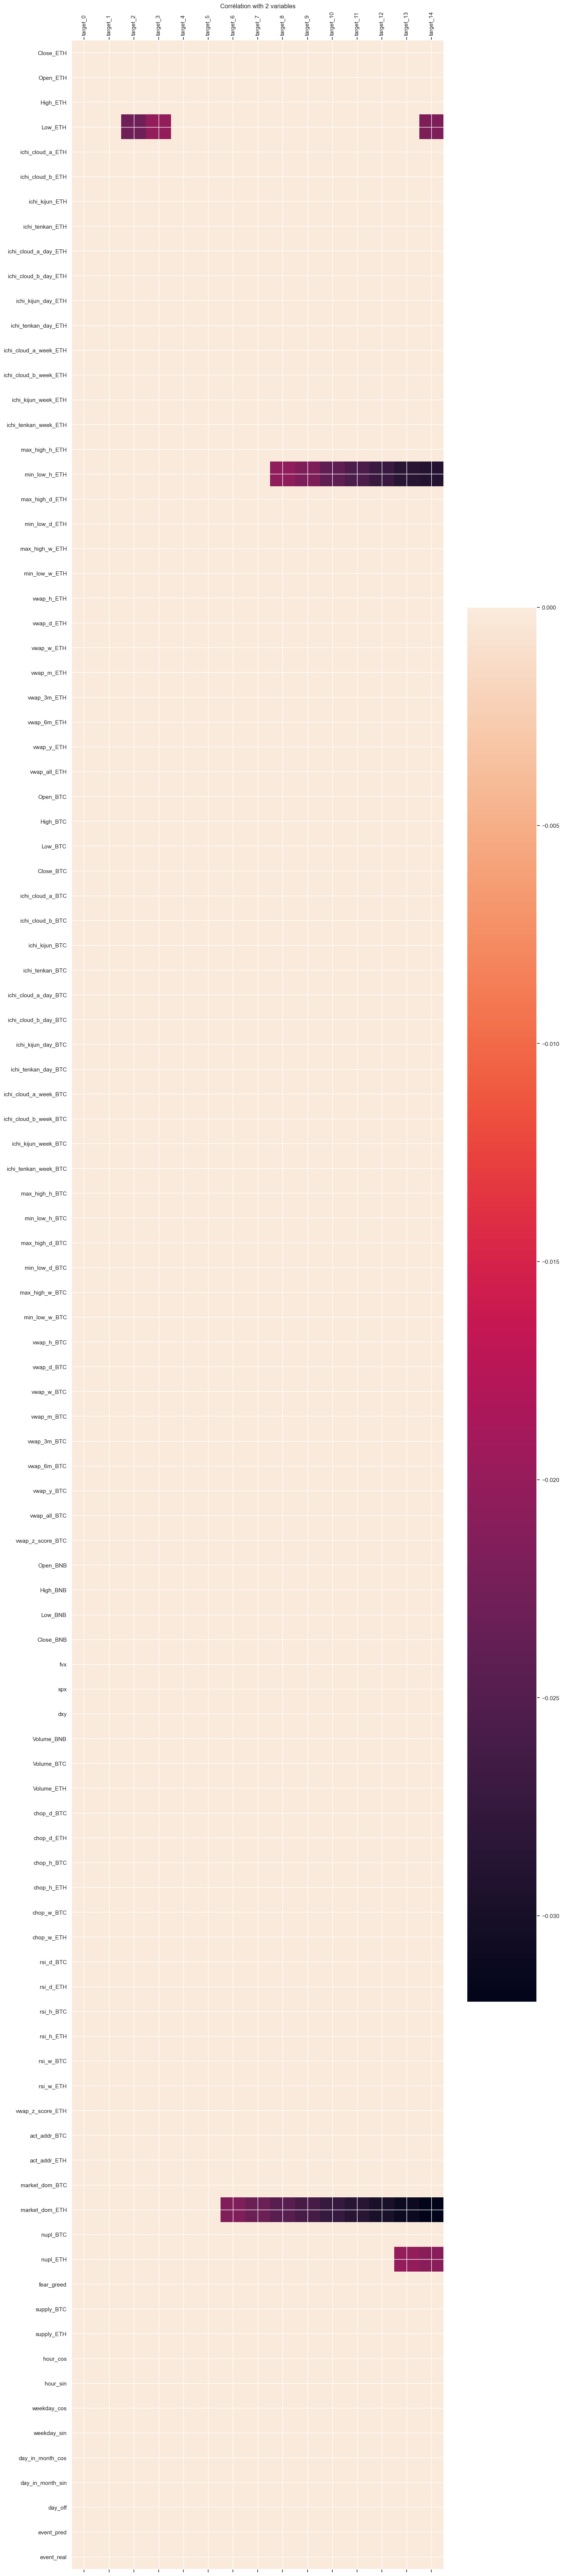

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

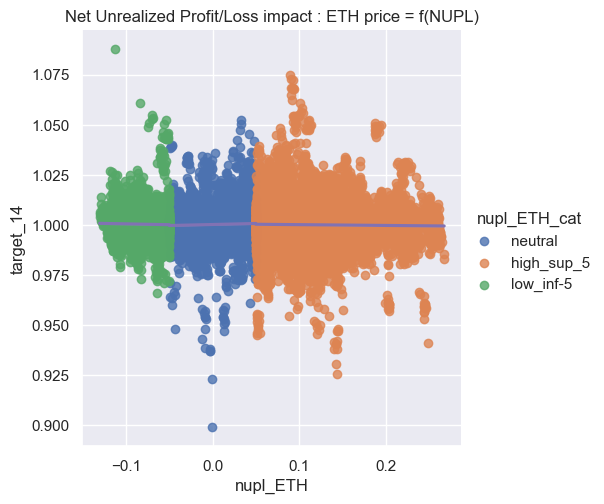

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

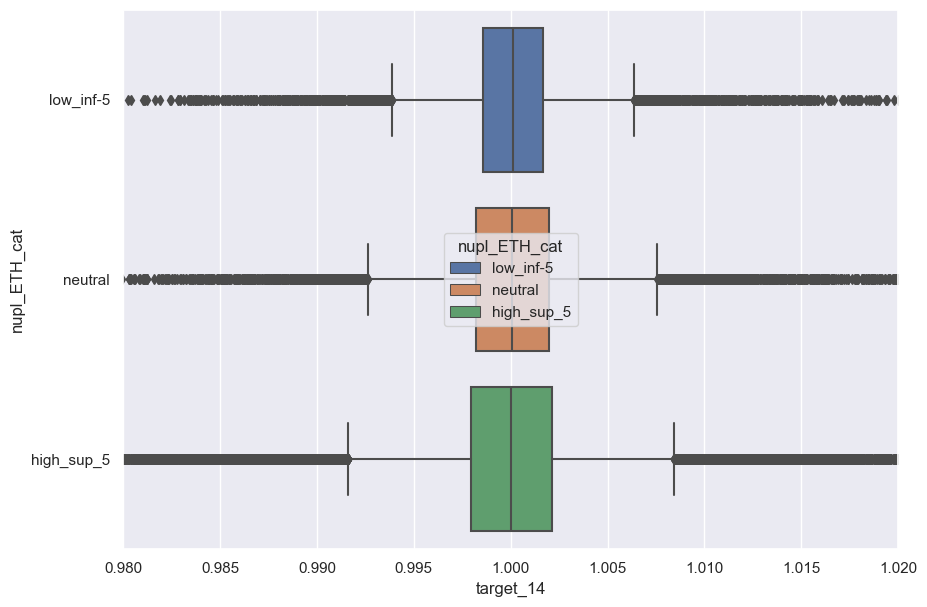

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    99348.000000
mean         1.000109
std          0.005420
min          0.899006
25%          0.998097
50%          1.000043
75%          1.002024
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    99348.000000
mean         1.000015
std          0.002020
min          0.907143
25%          0.999259
50%          1.000006
75%          1.000773
max          1.053076
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

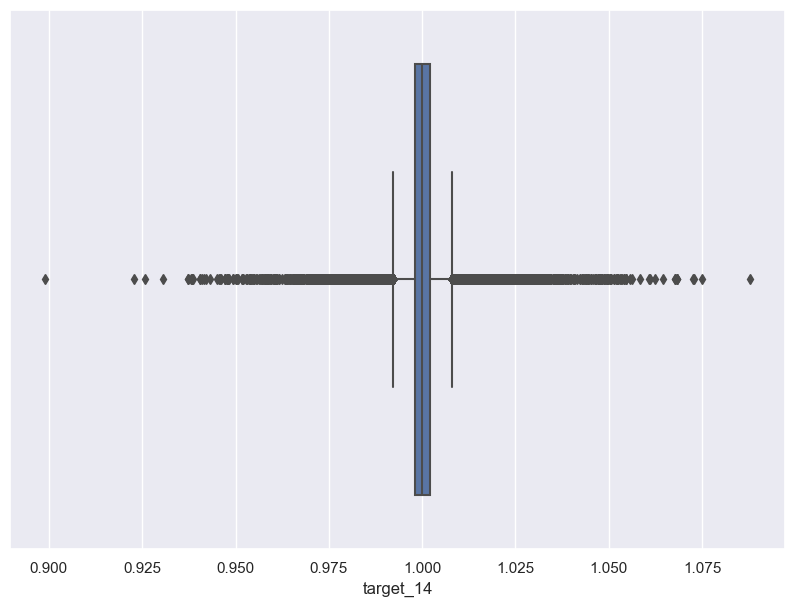

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00101639, 0.99995503, 0.99700929, ..., 1.00052169, 1.00020238,
        1.00092195],
       [0.99893971, 0.99599696, 0.99791986, ..., 0.99918681, 0.99990565,
        0.99953725],
       [0.99705413, 0.99897906, 0.99980211, ..., 1.00096697, 1.00059817,
        0.99883065]])

In [89]:
y_train_sca

array([[ 0.10101638,  0.08206356, -0.1095705 , ..., -0.0421827 ,
         0.02309924, -0.05060617],
       [-0.0337505 , -0.22529638, -0.0569044 , ..., -0.09268769,
        -0.16635918, -0.31580706],
       [-0.2063667 , -0.03796204, -0.15795036, ..., -0.14742507,
        -0.29688421, -0.36845619],
       ...,
       [ 0.24087171, -0.0261196 , -0.76713361, ...,  0.11642661,
         0.03610296,  0.21711401],
       [-0.28152662, -1.02178824, -0.5380753 , ..., -0.21936725,
        -0.03853998, -0.13121396],
       [-0.75585374, -0.27162739, -0.06458668, ...,  0.22843814,
         0.1356658 , -0.3089626 ]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(99348, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
#epochs = 500 #100 #150 #6 #300
#patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in LIST_UNITS_AE: #[32, 64, 128]: #[104]: #
        for encoding_dim in LIST_UNITS_ENC_AE:#[16, 20, 32]:
            for dropout_autoenc in LIST_DROPOUT_AE: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=PATIENCE_AE, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if PATIENCE_AE == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 32)          1275936   
                                                                 
 model_1 (Functional)        (None, None, 102)         1168486   
                                                                 
Total params: 2444422 (9.32 MB)
Trainable params: 2444422 (9.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

3105/3105 [==============================] - 66s 21ms/step


(99348, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

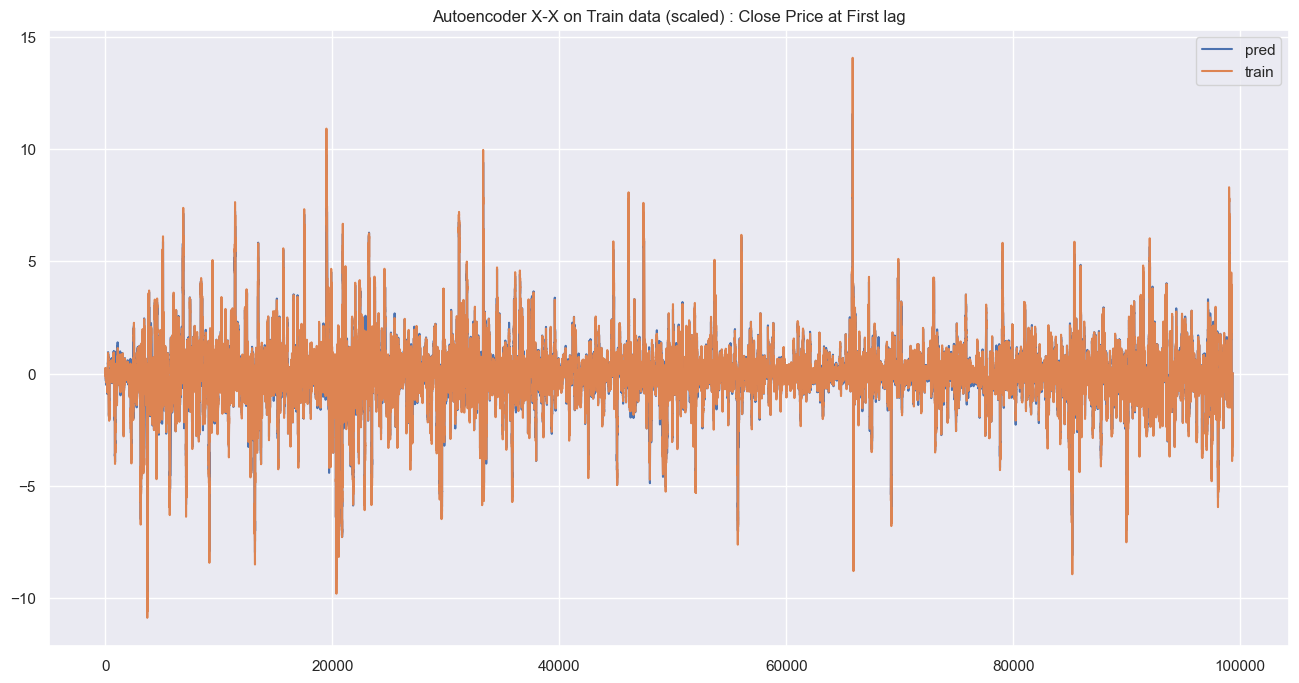

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(99348, 72, 102)
(99348, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.082121  0.095531  0.067014  0.074788          0.110692   
lag_1    0.064132  0.065835  0.053340  0.060999          0.096950   
lag_2    0.054007  0.054684  0.046591  0.053586          0.092461   
lag_3    0.049441  0.047822  0.042612  0.050113          0.090533   
lag_4    0.045671  0.043355  0.039477  0.047132          0.087199   
...           ...       ...       ...       ...               ...   
lag_67   0.038371  0.034361  0.031816  0.041130          0.046012   
lag_68   0.038318  0.034332  0.031786  0.041095          0.045984   
lag_69   0.038278  0.034302  0.031752  0.041058          0.045924   
lag_70   0.038233  0.034277  0.031723  0.041027          0.045894   
lag_71   0.038207  0.034239  0.031665  0.041004          0.045868   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.091816        0.100624         0.087710   
lag_1           0.072693        0.090635         0.077322   
lag_2           0.066782        0.083308         0.070228   
lag_3           0.063737        0.078839         0.064870   
lag_4           0.060695        0.074829         0.059064   
...                  ...             ...              ...   
lag_67          0.040708        0.045442         0.042247   
lag_68          0.040671        0.045405         0.042203   
lag_69          0.040615        0.045367         0.042174   
lag_70          0.040594        0.045329         0.042140   
lag_71          0.040549        0.045283         0.042110   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.108288              0.096701  ...    0.101638  0.085363   
lag_1               0.080118              0.073565  ...    0.048996  0.050661   
lag_2               0.068697              0.062276  ...    0.036798  0.045691   
lag_3               0.062636              0.056217  ...    0.032630  0.045998   
lag_4               0.058334              0.051689  ...    0.030224  0.046923   
...                      ...                   ...  ...         ...       ...   
lag_67              0.040753              0.037441  ...    0.023762  0.037034   
lag_68              0.040777              0.037456  ...    0.023771  0.036990   
lag_69              0.040799              0.037475  ...    0.023776  0.036952   
lag_70              0.040819              0.037489  ...    0.023774  0.036913   
lag_71              0.040847              0.037510  ...    0.023774  0.036879   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.083193     0.081409     0.088318          0.101008   
lag_1   0.051199     0.049451     0.049927          0.052440   
lag_2   0.044545     0.041260     0.042435          0.040717   
lag_3   0.044576     0.039680     0.039431          0.037517   
lag_4   0.044594     0.038030     0.036648          0.035389   
...          ...          ...          ...               ...   
lag_67  0.036703     0.033686     0.032369          0.029024   
lag_68  0.036683     0.033604     0.032340          0.029018   
lag_69  0.036673     0.033535     0.032316          0.029014   
lag_70  0.036666     0.033474     0.032297          0.029015   
lag_71  0.036661     0.033407     0.032274          0.029007   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.095410  0.067251    0.132032    0.111820  
lag_1           0.054887  0.034545    0.081220    0.048727  
lag_2           0.045029  0.022756    0.049869    0.034439  
lag_3           0.041243  0.017296    0.035885    0.026193  
lag_4           0.039054  0.015461    0.030277    0.022995  
...                  ...       ...         ...         ...  
lag_67          0.036511  0.010414    0.020038    0.018149  
lag_68          0.036505  0.010396    0.020029    0.018126  
lag_69          0.036501  0.010376    0.020023    0.018103  
lag_70          0.036493  0.010355    0.020015    0.018092  
lag_71          0.036487  0.01033

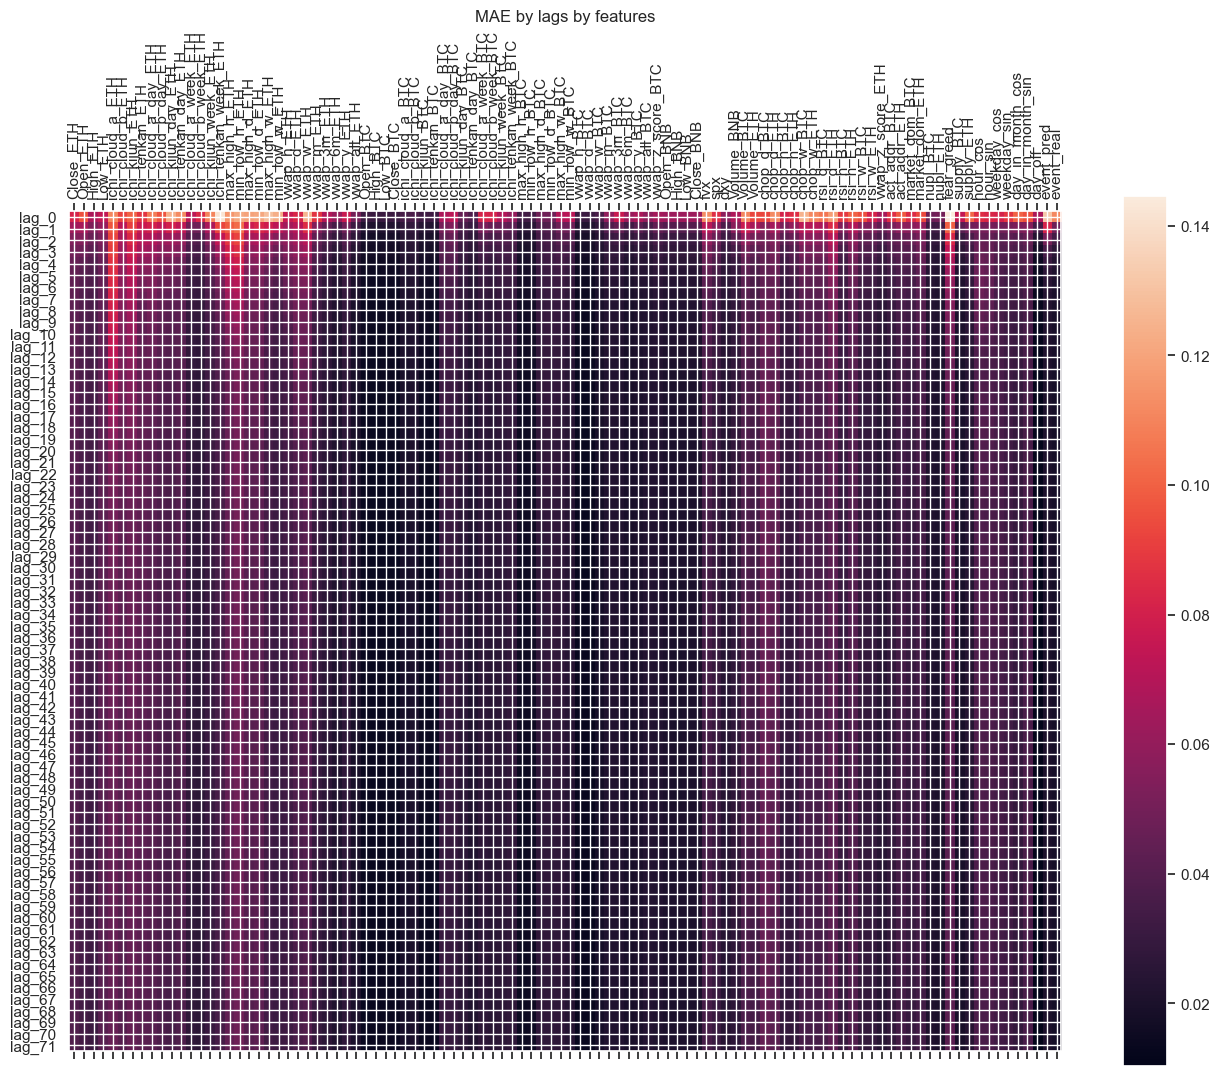

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

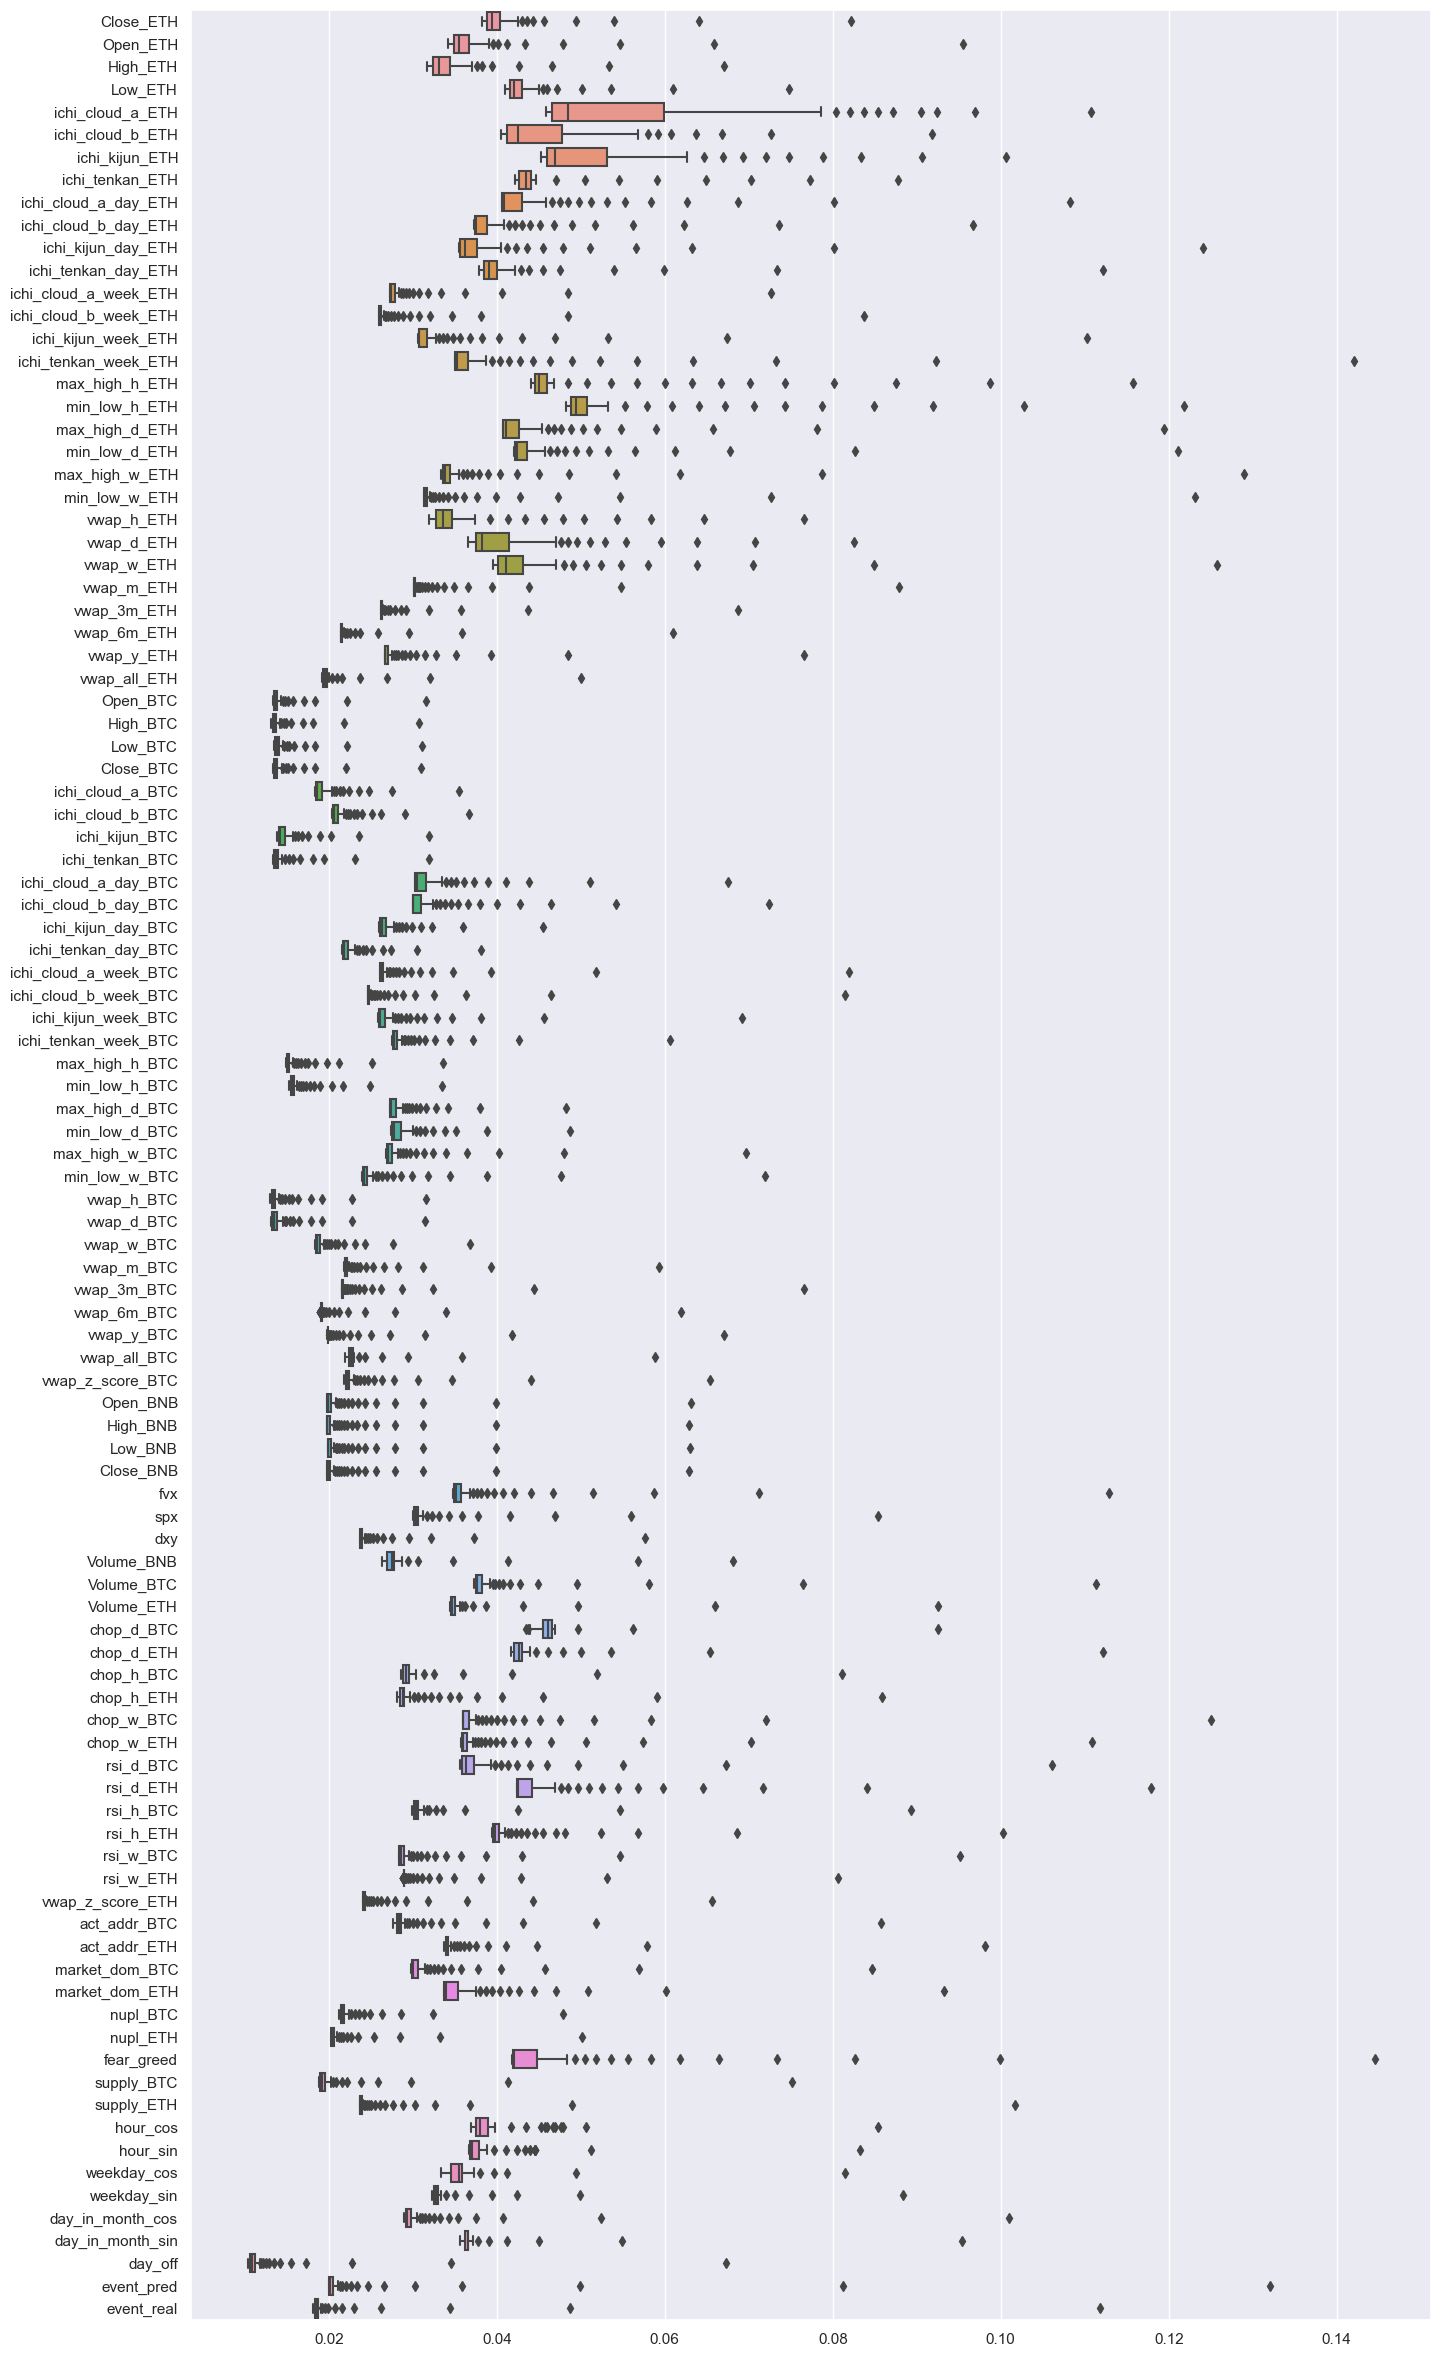

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.041032  0.037627  0.034551  0.043298          0.056287   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.046297        0.052005         0.045555              0.044539   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.040519  ...    0.025878  0.039815  0.038763     0.036149   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.034034           0.03129          0.037662  0.012424    0.023643   

   event_real  
0    0.020736  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

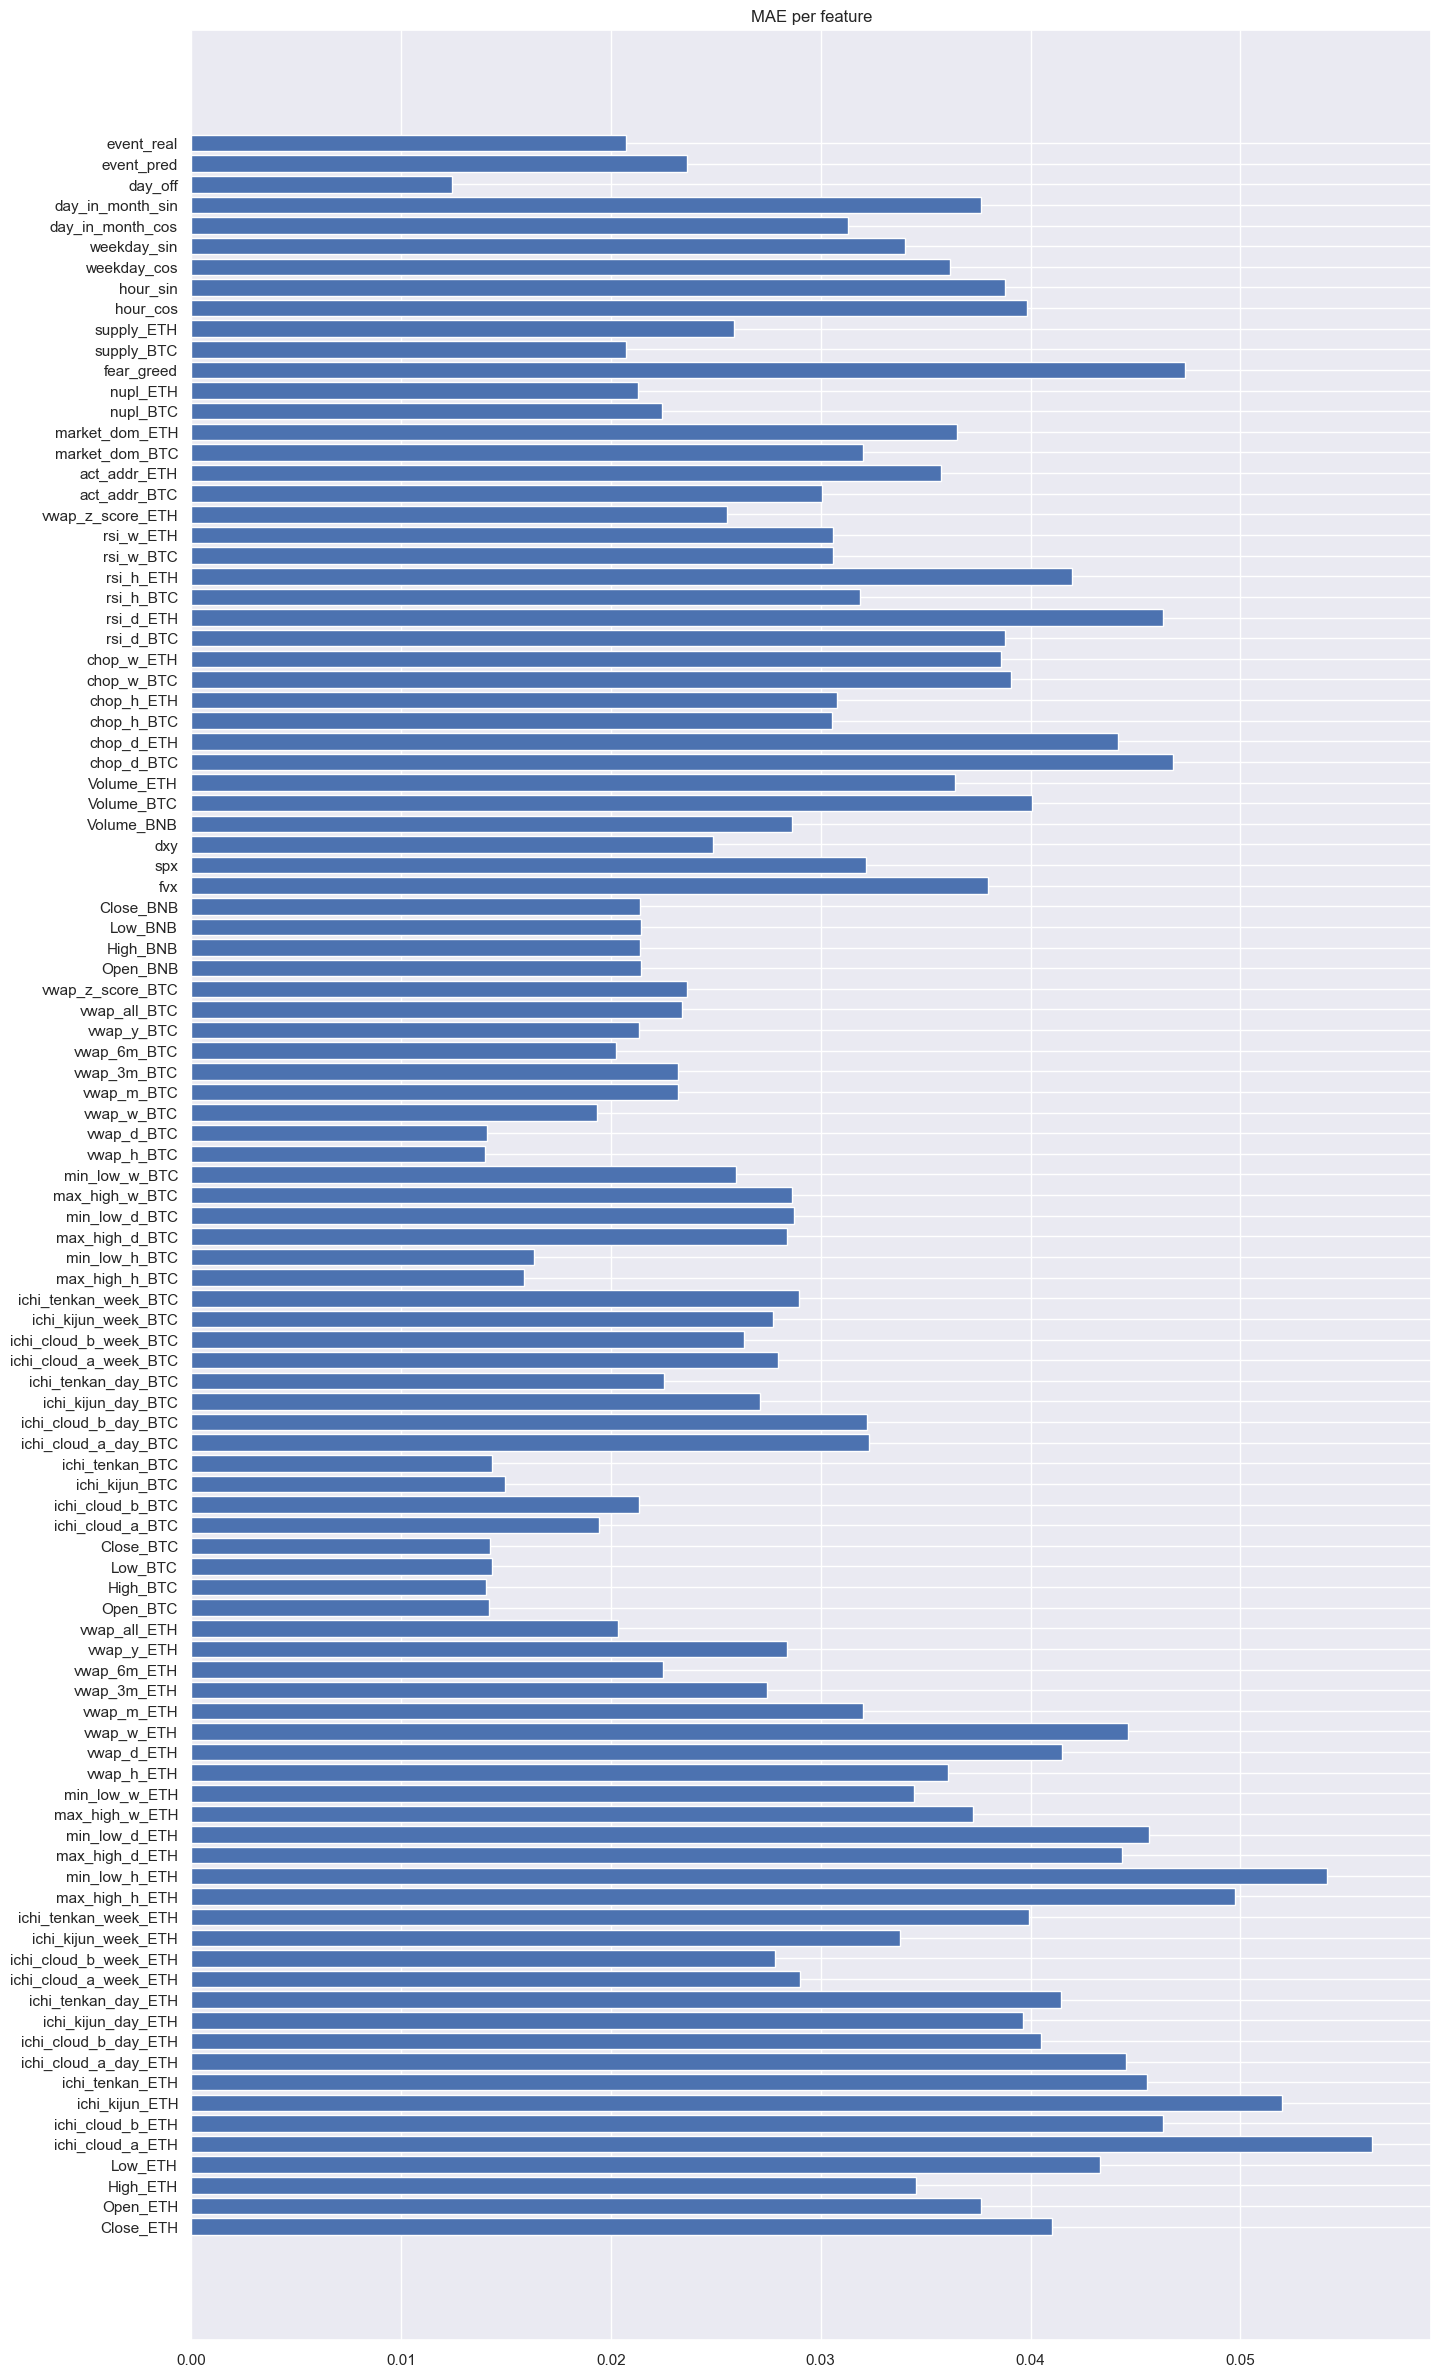

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(99348,)
(99348,)
[1196.32 1195.38 1194.55 ... 2223.54 2224.99 2223.29]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9995228 , 0.99965185, 0.99968785, ..., 1.000539  , 0.9998992 ,
       1.0008367 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 2223.54 2224.99 2223.29]
[1195.89436892 1196.37860343 1196.15929961 ... 2221.90194086 2223.79303906
 2223.58120267]


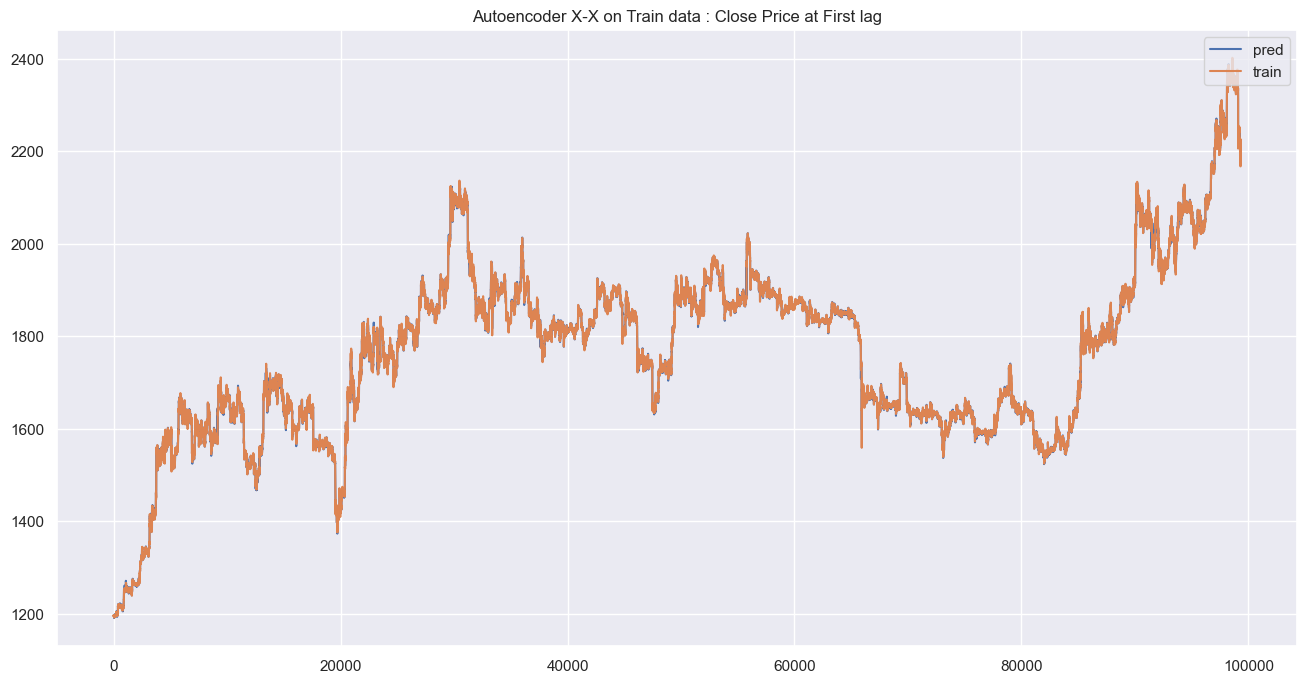

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

13/13 [==============================] - 1s 36ms/step


(412, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-12-12 06:10:00'

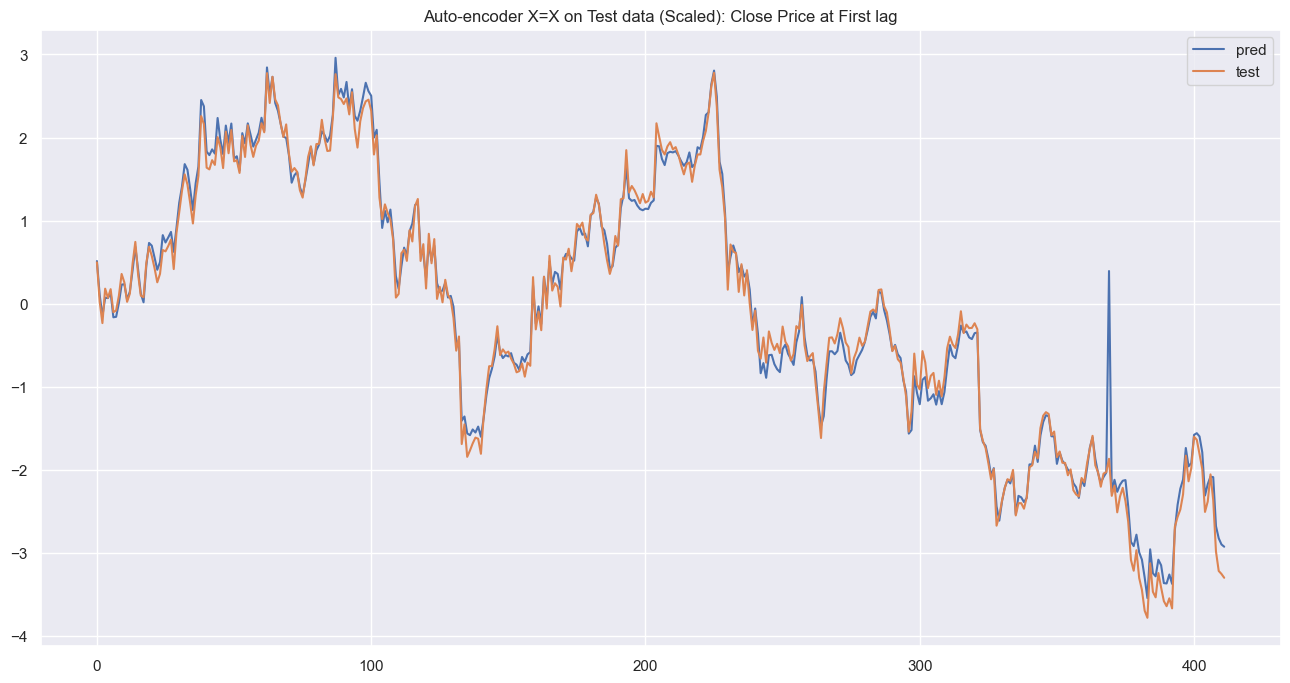

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [2220.74 2217.01 2213.27 2219.35 2217.78 2220.76 2221.46 2223.4  2224.54]
X test pred :  [2221.02299736 2218.51760787 2214.86267896 2217.32781632 2217.73431641
 2219.93247303 2220.32890325 2221.98699984 2222.92622805]


[2220.74 2217.01 2213.27 2219.35 2217.78 2220.76 2221.46 2223.4  2224.54
 2230.95 2229.46 2228.1  2225.7  2228.58 2229.28 2226.71 2225.95 2230.42
 2235.02 2237.16 2233.46 2231.01 2229.02 2228.15 2226.9  2228.61 2229.67
 2231.34 2228.01 2231.96 2234.81 2237.82 2235.66 2232.42 2230.15 2228.46
 2229.13 2231.8  2231.79 2228.98 2228.47 2227.76 2229.07 2228.9  2226.39
 2226.84 2224.84 2226.42 2223.82 2223.03 2223.7  2222.82 2224.17 2224.03
 2223.45 2225.89 2225.5  2223.51 2222.75 2220.8  2221.15 2222.37 2221.83
 2218.86 2216.3  2214.32 2215.04 2212.84 2208.39 2210.8  2210.38 2212.01
 2216.98 2217.98 2216.43 2216.9  2217.95 2223.76 2225.31 2223.2  2224.75
 2225.14 2228.09 2223.87 2220.11 2216.01 2220.56 2224.57 2229.4  2226.38
 2224.93 2223.26 2223.49 2224.68 2221.93 2215.43 2217.43 2217.31 2217.54
 2220.74 2216.68 2215.   2213.3  2207.54 2206.56 2208.36 2211.15 2205.7
 2204.08 2191.13 2190.1  2198.99 2198.67 2197.96 2198.82 2190.34 2192.99
 2195.5  2189.19 2191.29 2185.52 2192.92 2191.81 219

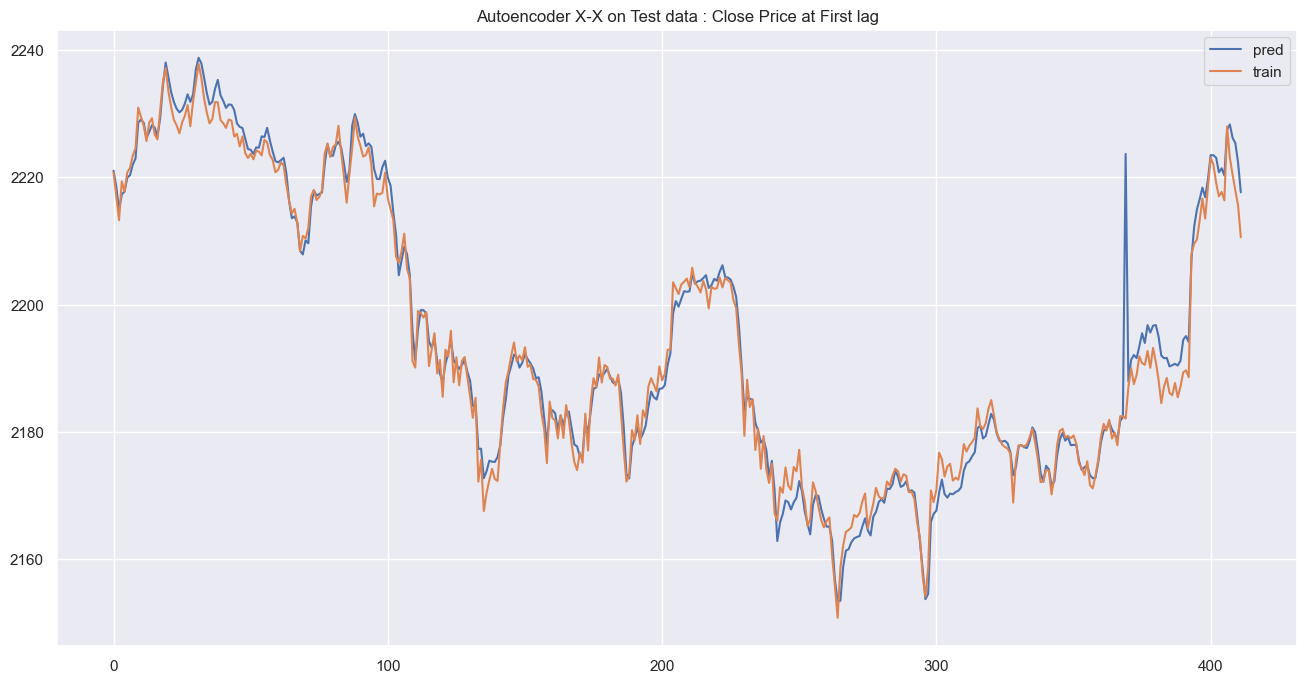

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(412, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.1941794507761412

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(412, 72, 102)
(412, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.082121  0.095531  0.067014  0.074788          0.110692   
lag_1    0.064132  0.065835  0.053340  0.060999          0.096950   
lag_2    0.054007  0.054684  0.046591  0.053586          0.092461   
lag_3    0.049441  0.047822  0.042612  0.050113          0.090533   
lag_4    0.045671  0.043355  0.039477  0.047132          0.087199   
...           ...       ...       ...       ...               ...   
lag_67   0.062900  0.053570  0.042299  0.067934          0.068654   
lag_68   0.062545  0.053685  0.042672  0.067884          0.068361   
lag_69   0.062309  0.053256  0.042480  0.067985          0.067990   
lag_70   0.062133  0.053229  0.042129  0.067886          0.067597   
lag_71   0.061956  0.053378  0.041629  0.067954          0.067133   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.091816        0.100624         0.087710   
lag_1           0.072693        0.090635         0.077322   
lag_2           0.066782        0.083308         0.070228   
lag_3           0.063737        0.078839         0.064870   
lag_4           0.060695        0.074829         0.059064   
...                  ...             ...              ...   
lag_67          0.058851        0.069601         0.061882   
lag_68          0.058758        0.069714         0.061842   
lag_69          0.058511        0.069975         0.061900   
lag_70          0.058207        0.069736         0.061610   
lag_71          0.057949        0.070003         0.061358   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.108288              0.096701  ...  0.085363  0.083193   
lag_1               0.080118              0.073565  ...  0.050661  0.051199   
lag_2               0.068697              0.062276  ...  0.045691  0.044545   
lag_3               0.062636              0.056217  ...  0.045998  0.044576   
lag_4               0.058334              0.051689  ...  0.046923  0.044594   
...                      ...                   ...  ...       ...       ...   
lag_67              0.308085              0.044765  ...  0.038662  0.039716   
lag_68              0.307461              0.044685  ...  0.038590  0.039721   
lag_69              0.306863              0.044790  ...  0.038616  0.039638   
lag_70              0.306287              0.044855  ...  0.038680  0.039296   
lag_71              0.305695              0.045092  ...  0.039005  0.039081   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.081409     0.088318          0.101008          0.095410   
lag_1      0.049451     0.049927          0.052440          0.054887   
lag_2      0.041260     0.042435          0.040717          0.045029   
lag_3      0.039680     0.039431          0.037517          0.041243   
lag_4      0.038030     0.036648          0.035389          0.039054   
...             ...          ...               ...               ...   
lag_67     0.064222     0.045751          0.111306          0.596270   
lag_68     0.064309     0.045669          0.111621          0.596406   
lag_69     0.064239     0.045482          0.111939          0.596503   
lag_70     0.064221     0.045326          0.112254          0.596594   
lag_71     0.064244     0.045167          0.112443          0.596663   

         day_off  event_pred  event_real  dataset  
lag_0   0.067251    0.132032    0.111820    TRAIN  
lag_1   0.034545    0.081220    0.048727    TRAIN  
lag_2   0.022756    0.049869    0.034439    TRAIN  
lag_3   0.017296    0.035885    0.026193    TRAIN  
lag_4   0.015461    0.030277    0.022995    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.012189    0.043943    0.036277     TEST  
lag_68  0.012146    0.043837    0.036397     TEST  
lag_69  0.011998    0.043805    0.036490     TEST  
lag_70  0.011925    0.043855    0.036735     TEST  
lag_71  0.011934    0.043790    0.036832     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.067385  0.059571  0.049861  0.069847          0.083174   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.067402        0.077969         0.067052              0.326065   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.048272  ...    0.231874  0.052848  0.042189     0.063402   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0      0.05994          0.096783          0.564362  0.014942    0.057129   

   event_real  
0    0.041076  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

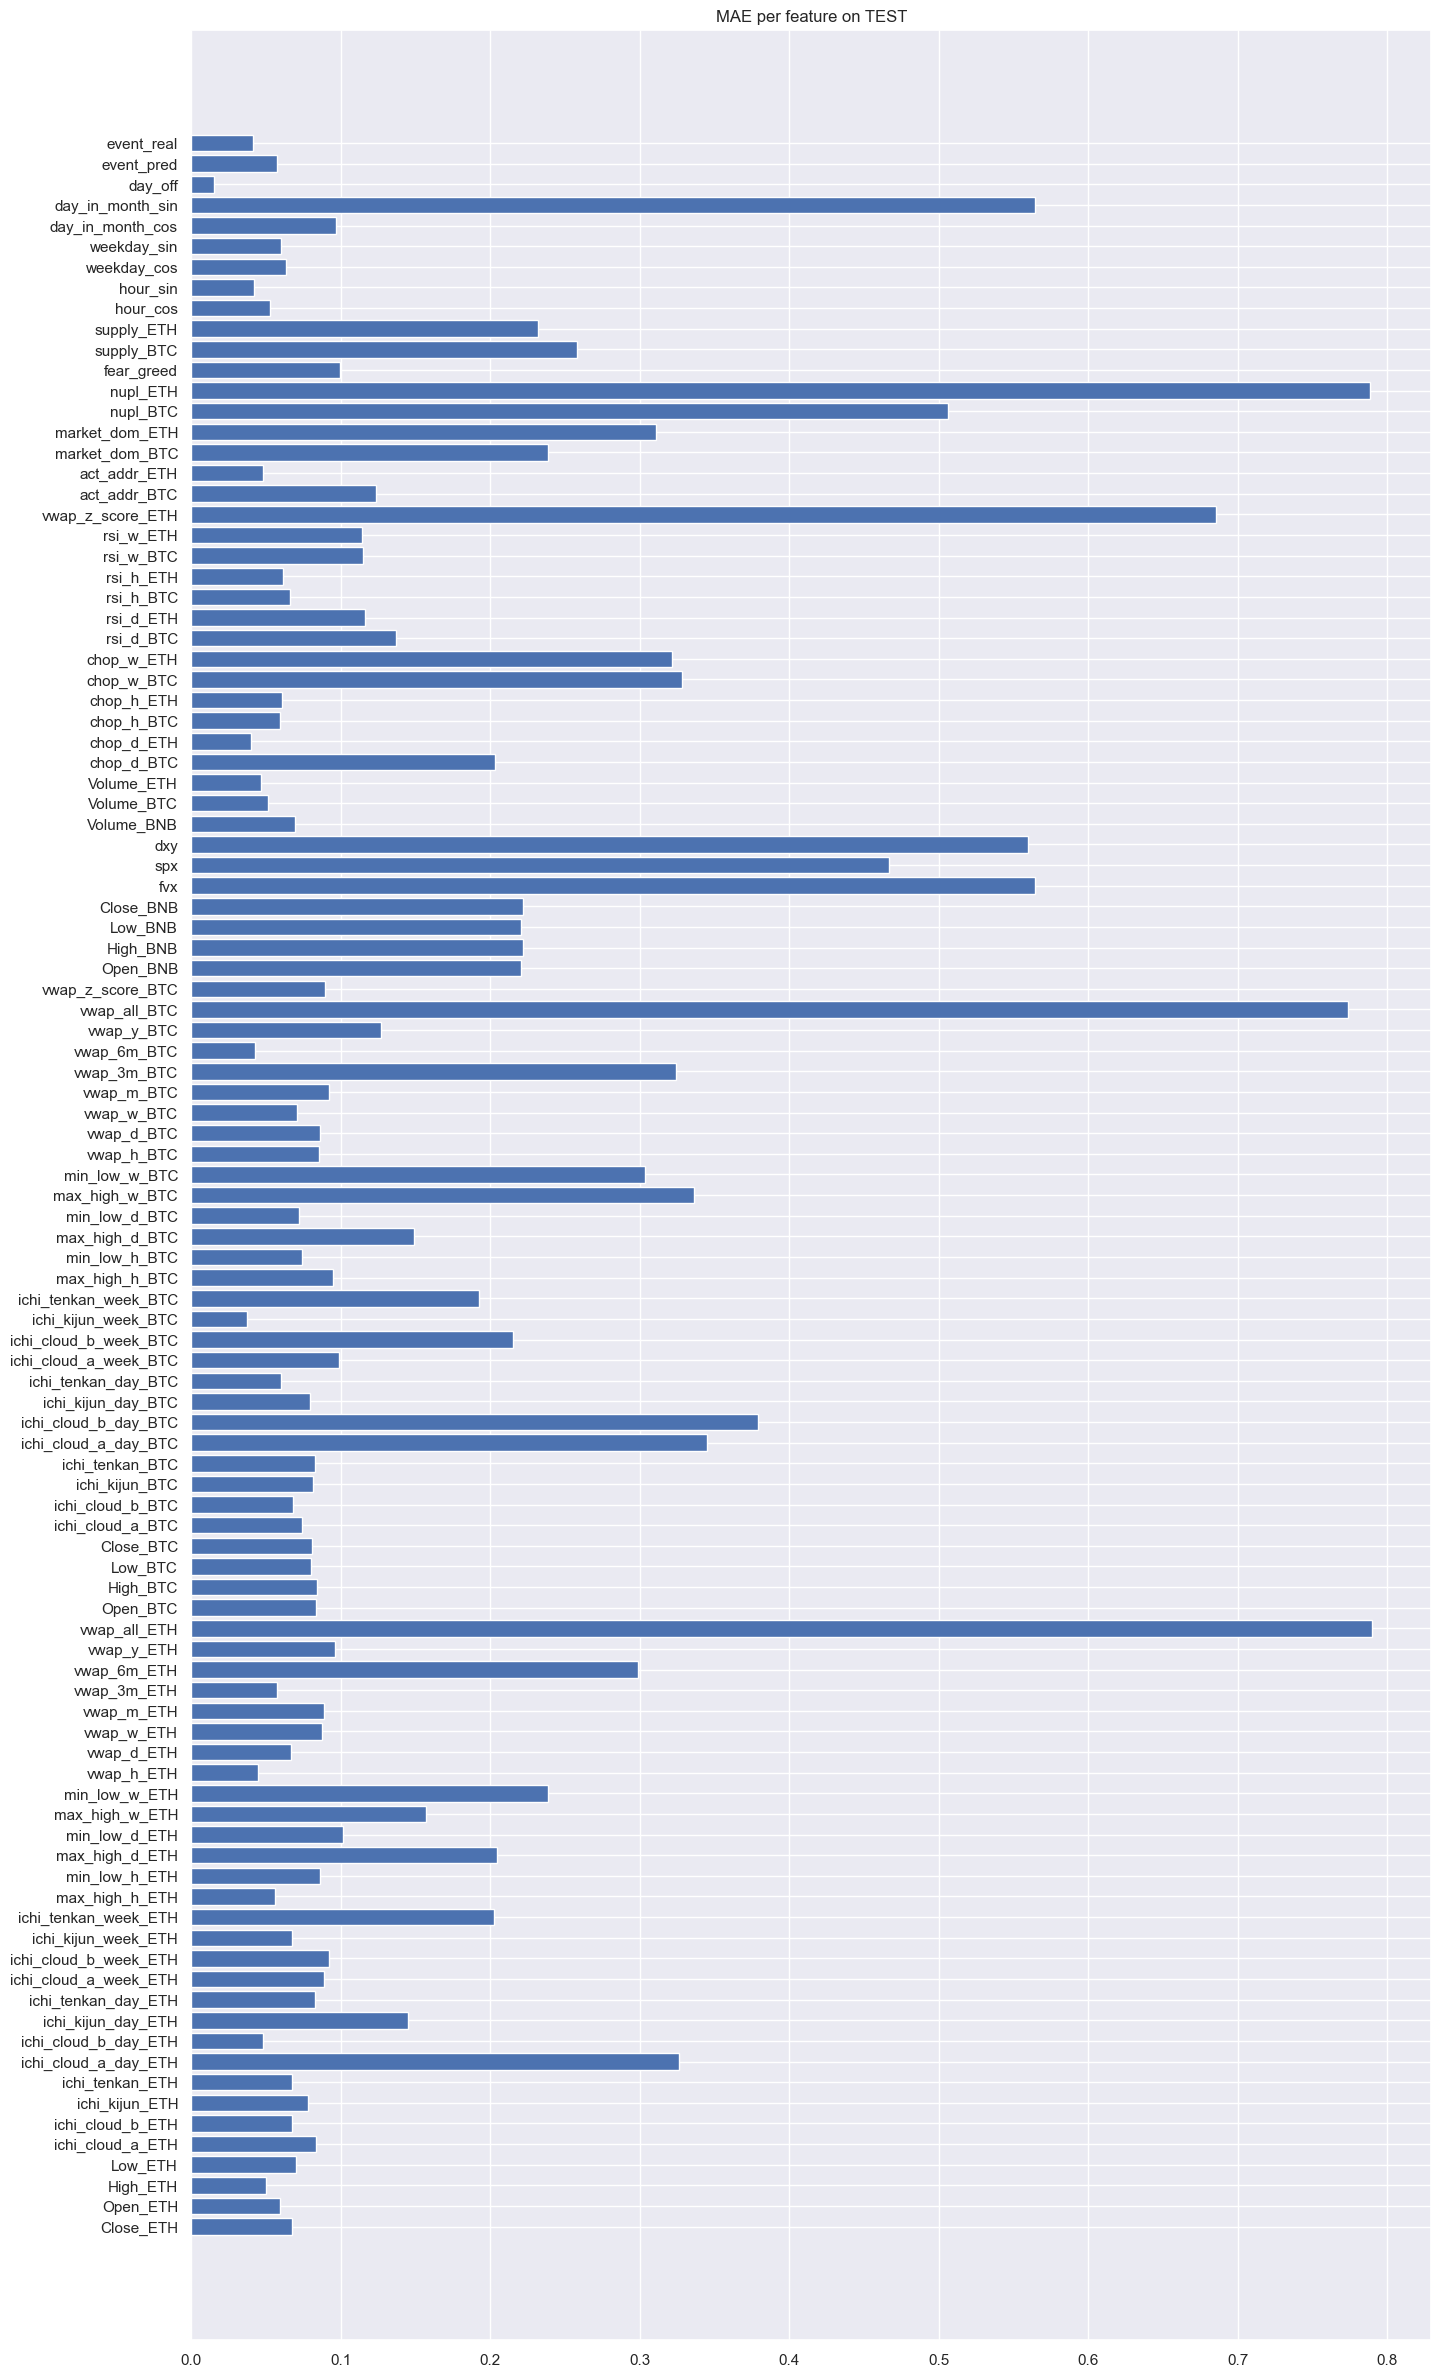

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.06738489, 0.05957092, 0.04986074, 0.06984707, 0.08317417,
       0.06740223, 0.0779692 , 0.06705245, 0.32606504, 0.04827233,
       0.14482333, 0.08246809, 0.0890853 , 0.09240538, 0.06712572,
       0.20229745, 0.05569144, 0.08641289, 0.20439381, 0.10136111,
       0.15730647, 0.23869492, 0.04431576, 0.0665871 , 0.08718372,
       0.08905302, 0.05718045, 0.29872092, 0.09613264, 0.79004931,
       0.08313558, 0.0841525 , 0.07980873, 0.08044725, 0.07418518,
       0.06777777, 0.08130239, 0.08267497, 0.34470061, 0.37886068,
       0.07970623, 0.05972491, 0.09897034, 0.21528567, 0.03726553,
       0.19259739, 0.09474713, 0.07430243, 0.14930454, 0.07179299,
       0.33617598, 0.30339931, 0.08544474, 0.08632475, 0.07084633,
       0.09237711, 0.32440321, 0.04250972, 0.12679112, 0.7738936 ,
       0.08954591, 0.22080948, 0.22210722, 0.22058553, 0.22195874,
       0.5642866 , 0.46674997, 0.5594673 , 0.06965701, 0.05117727,
       0.0468389 , 0.20325732, 0.03979172, 0.05909984, 0.06097

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.11573486757559213

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.082121
1       TRAIN   Close_ETH  0.064132
2       TRAIN   Close_ETH  0.054007
3       TRAIN   Close_ETH  0.049441
4       TRAIN   Close_ETH  0.045671
...       ...         ...       ...
14683    TEST  event_real  0.036277
14684    TEST  event_real  0.036397
14685    TEST  event_real  0.036490
14686    TEST  event_real  0.036735
14687    TEST  event_real  0.036832

[14688 rows x 3 columns]

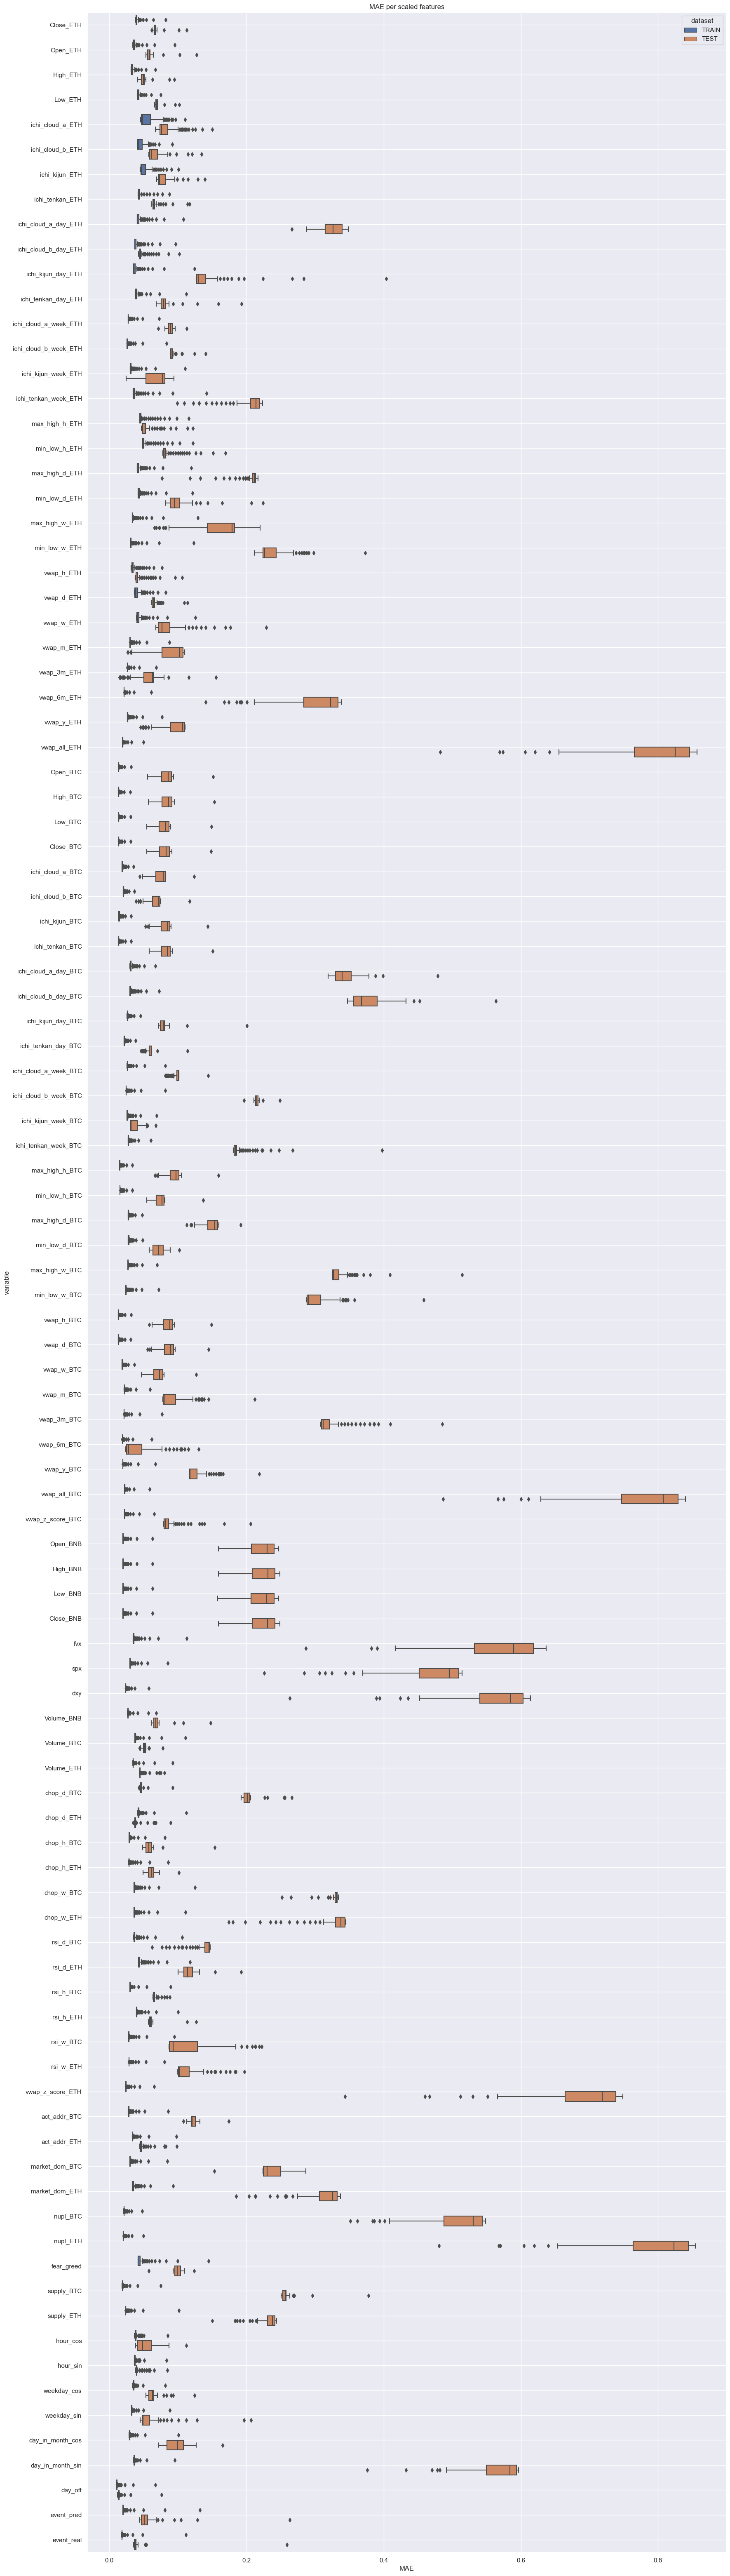

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(99348, 72, 102)
(99348, 72, 102)
(72, 102)
(412, 72, 102)
(412, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0   0.003592  0.003214  0.002891  0.00435          0.006516          0.004384   
0   0.007816  0.006150  0.004694  0.00831          0.011679          0.007423   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0        0.005938         0.004731              0.003723   
0        0.010949         0.008442              0.118991   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.002935  ...  0.002742  0.002545     0.002541     0.002327   
0              0.004116  ...  0.004450  0.003189     0.006361     0.005795   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.001882          0.002456  0.000636    0.001689    0.001413   
0          0.012594          0.330166  0.000527    0.013716    0.008089   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

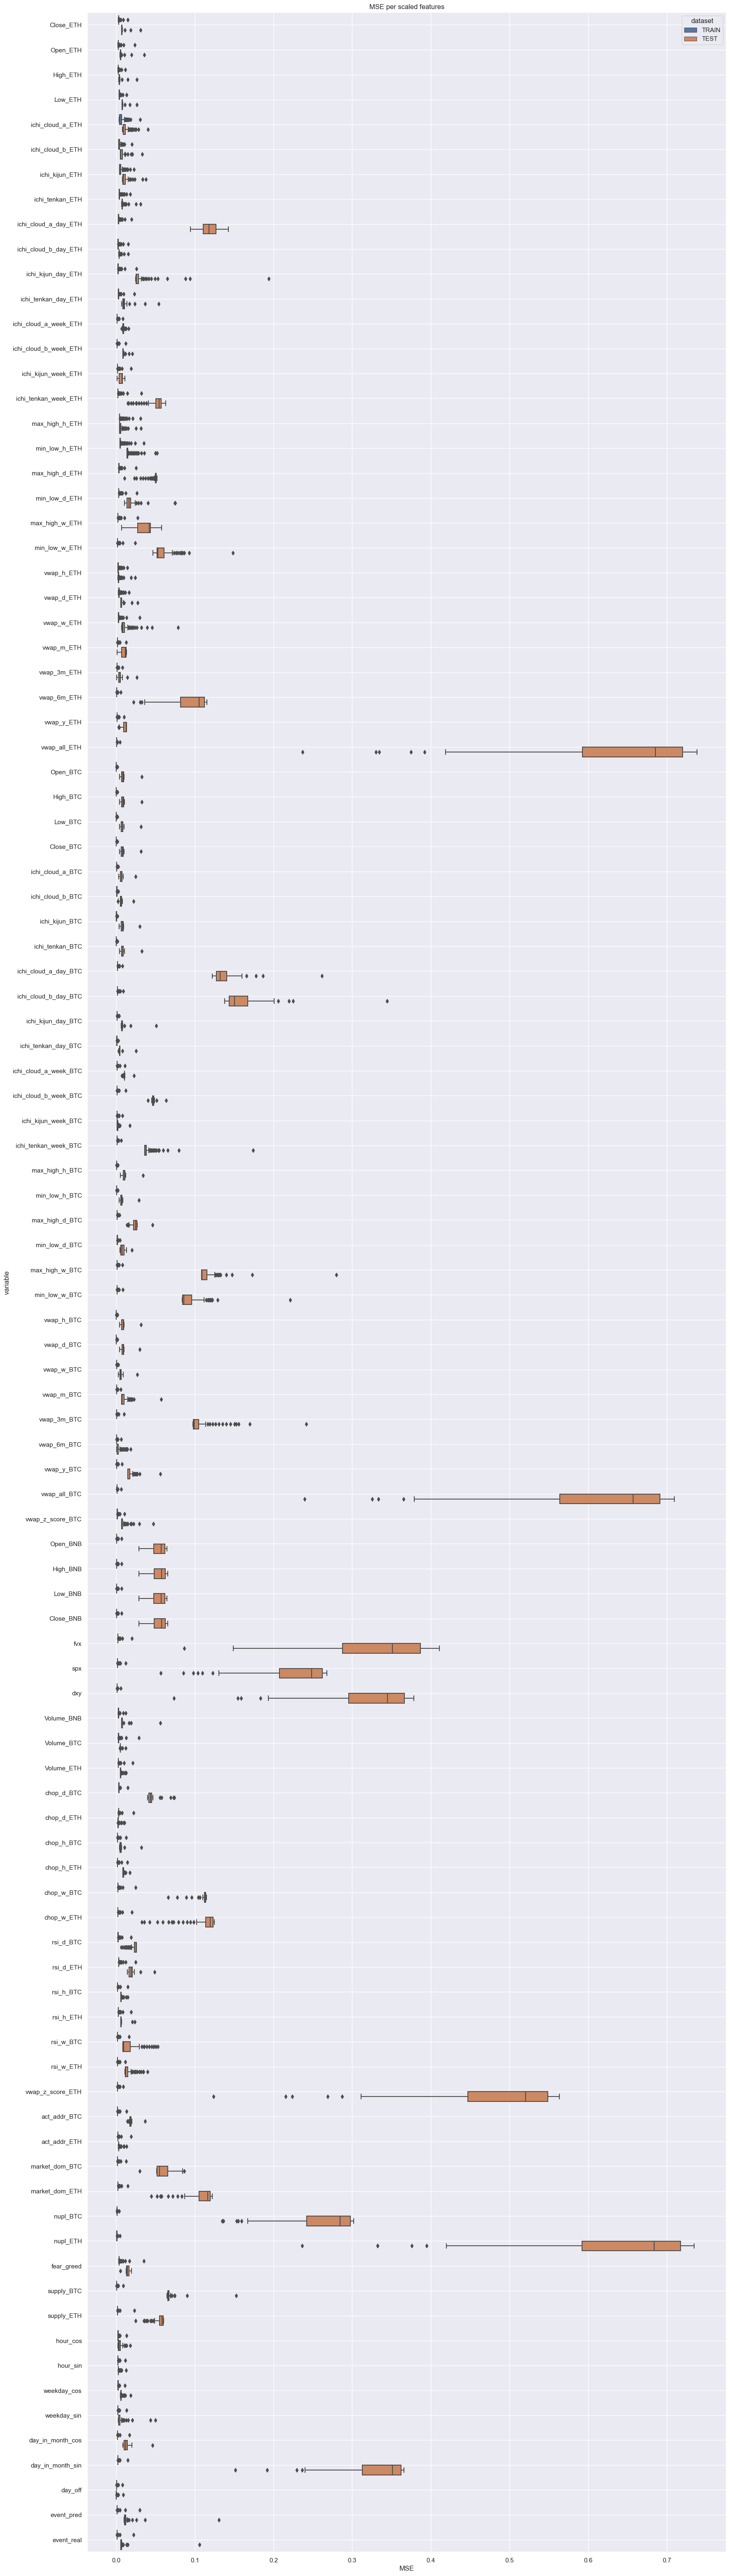

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

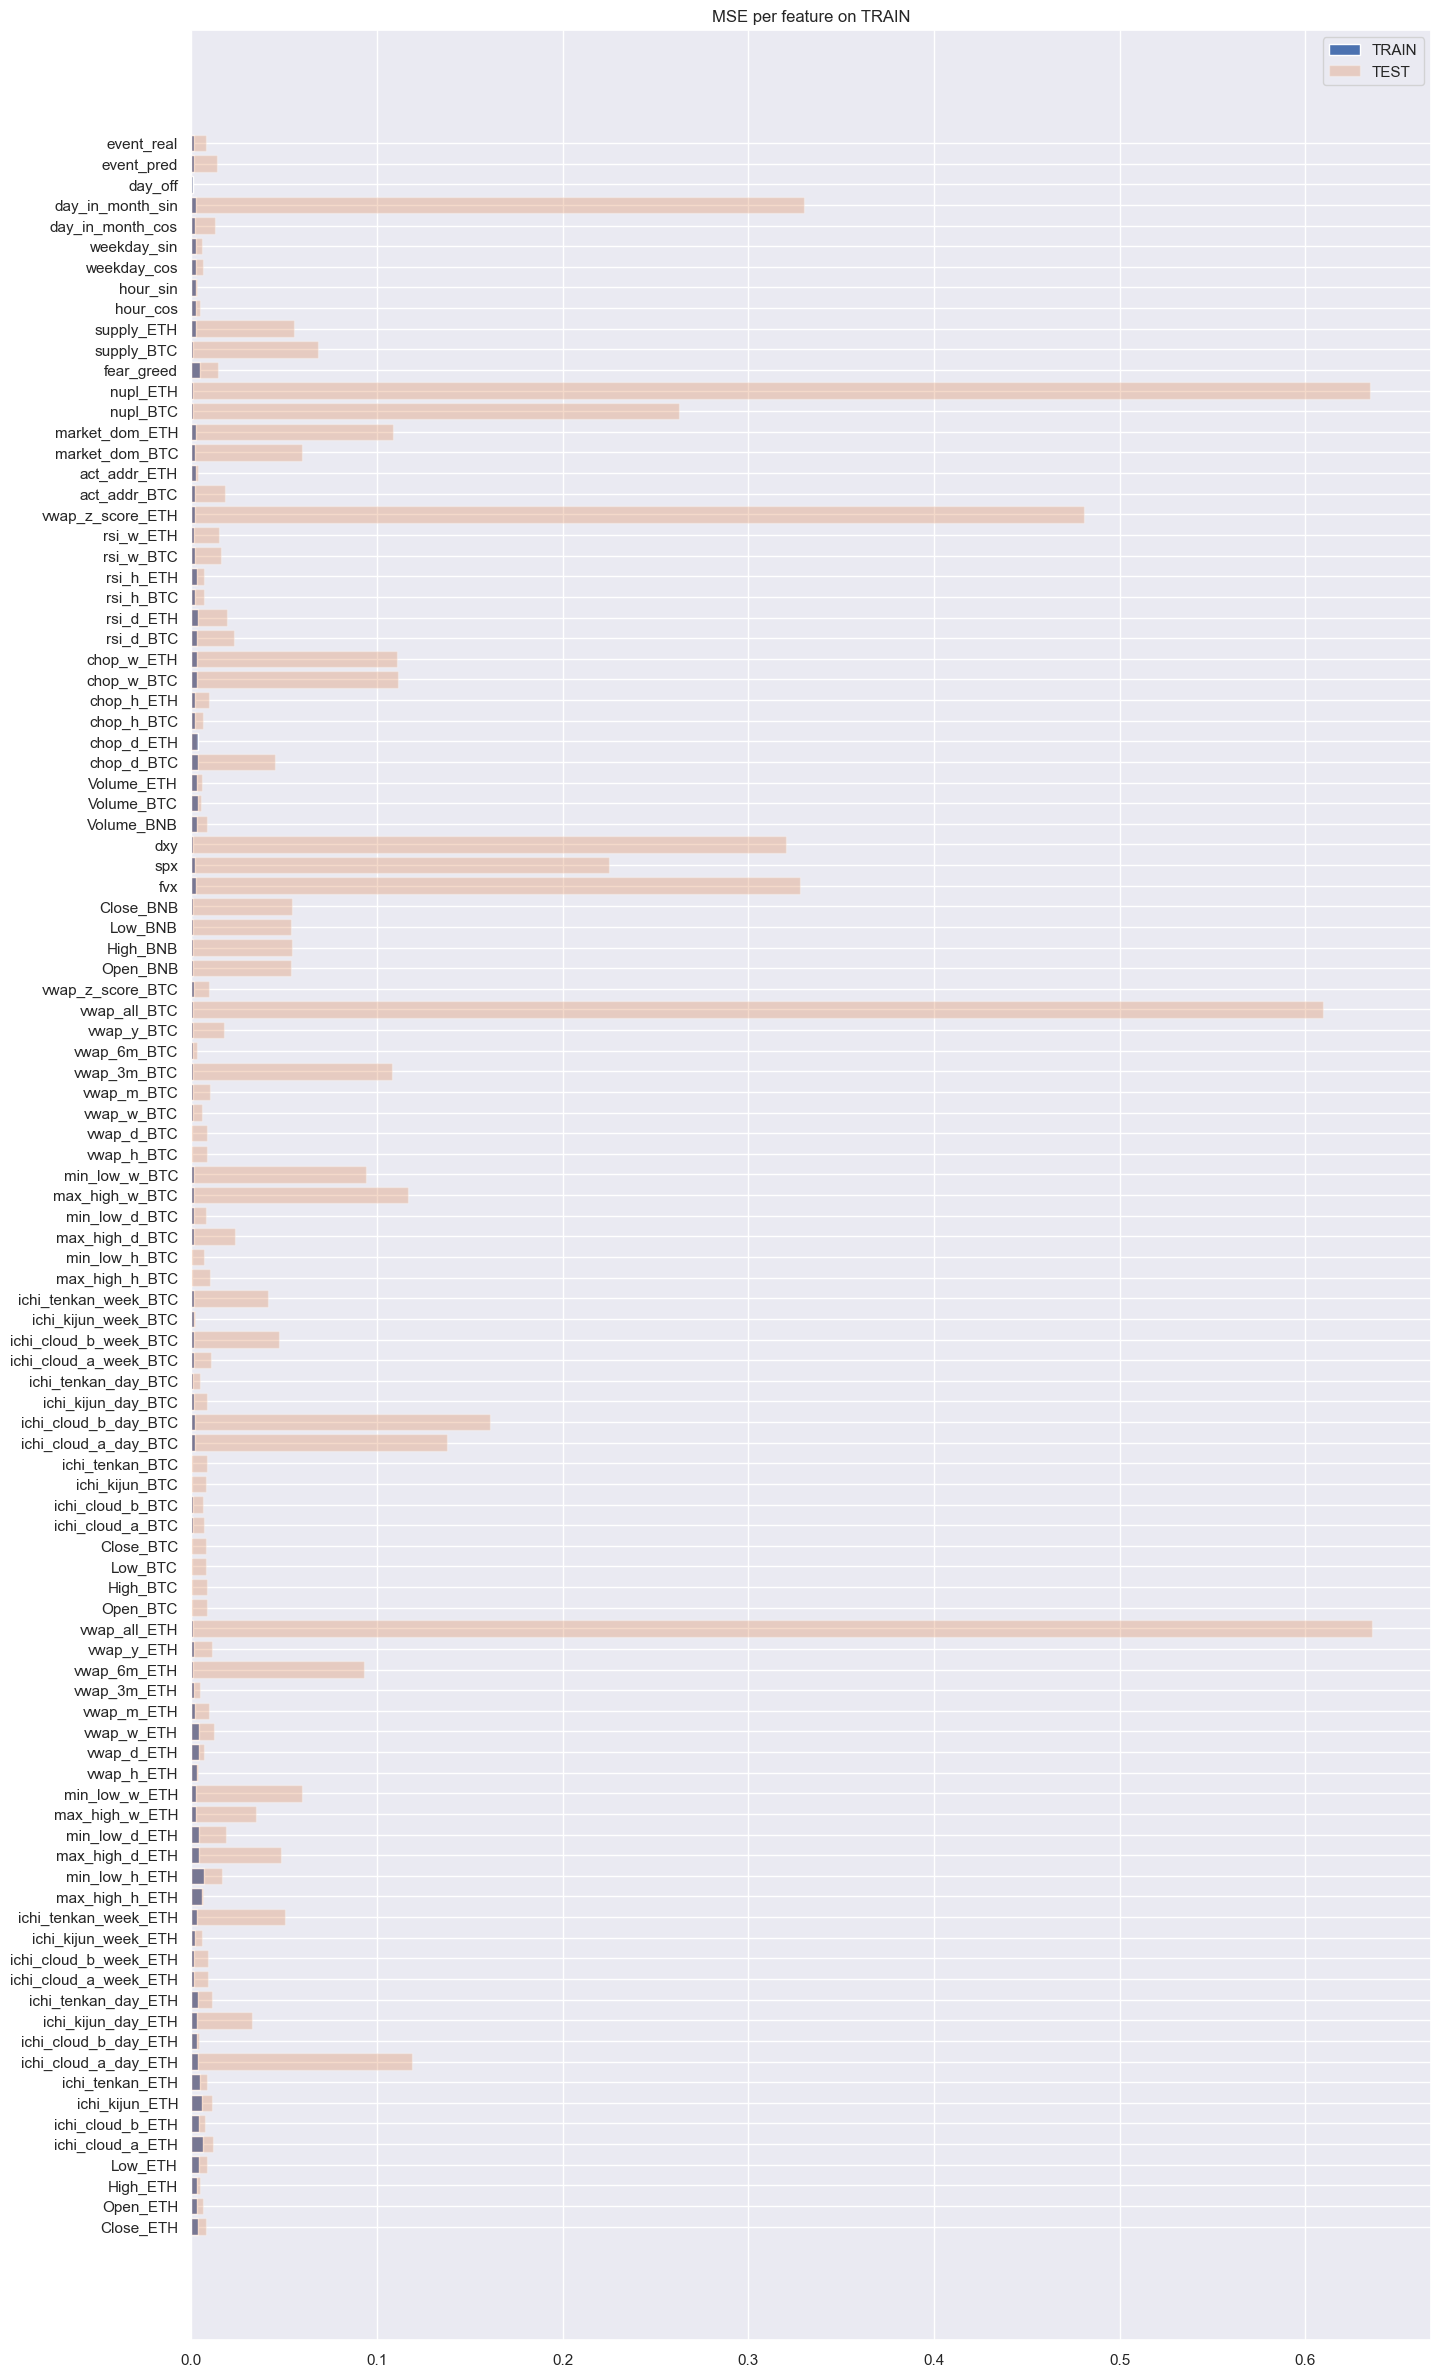

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[ 0.05395114, -0.11921711, -0.13893236, ...,  0.01991847,
          0.04298189,  0.20017953],
        [-0.11214189,  0.00842549, -0.21881573, ...,  0.02666084,
         -0.14524296, -0.06414954],
        [ 0.07842252, -0.09300585, -0.03287516, ..., -0.03090288,
         -0.0630329 , -0.10072941],
        ...,
        [-0.03209377,  0.19658528,  0.15552072, ..., -0.11174905,
         -0.06897826,  0.16266501],
        [ 0.4209378 ,  0.17749971,  0.08153384, ..., -0.21711984,
         -0.09003516, -0.00667564],
        [ 0.18778928,  0.2079123 , -0.31337667, ..., -0.05710671,
         -0.08108387,  0.26985705]], dtype=float32),
 array([-0.05363459, -0.06308154, -0.00778699, -0.03157371,  0.05700658,
         0.01604337, -0.17788525,  0.01591917,  0.03663067,  0.1884148 ,
         0.414919  ,  0.06049614, -0.07926945,  0.06767726, -0.04818252,
        -0.04144146,  0.12644051, -0.03456604,  0.13681214, -0.01492193,
        -0.01343331, -0.01971458, -0.0941205 , -0.10672063, -0.035

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(99348, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    PATIENCE_PRED = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=PATIENCE_PRED,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if PATIENCE_PRED == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

3105/3105 [==============================] - 35s 11ms/step


(99348, 72, 32)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

13/13 [==============================] - 0s 18ms/step


(412, 72, 32)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((99348, 72, 36), (412, 72, 36))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



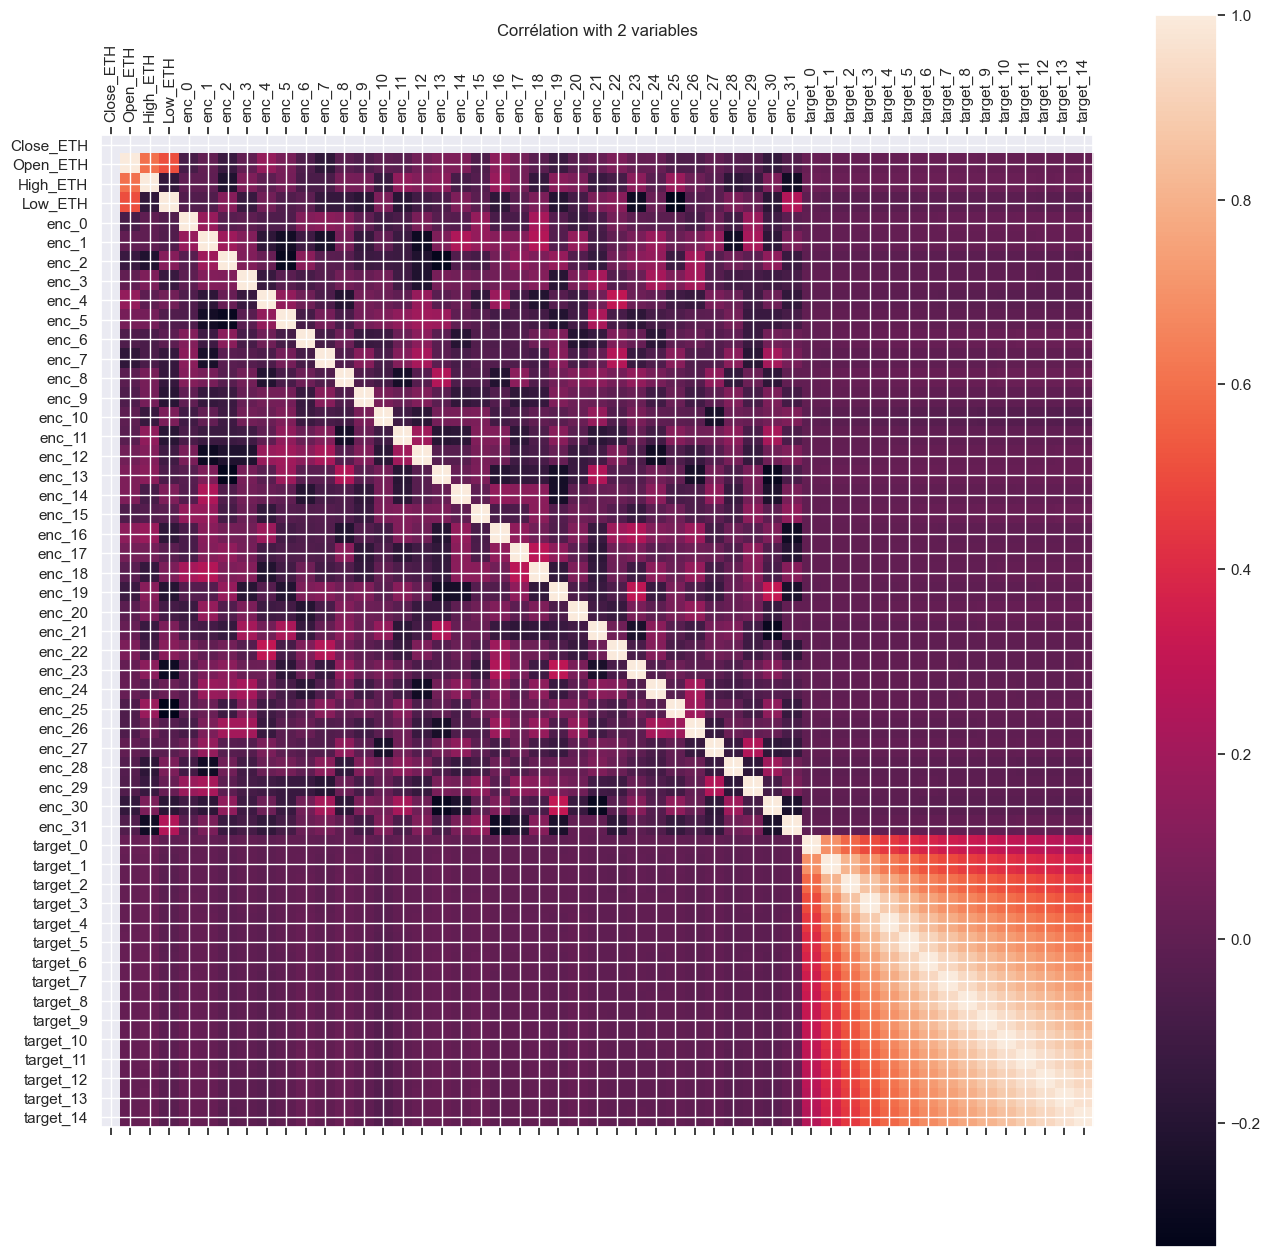

In [140]:
fig = plot_corr(corr_matrix_min)

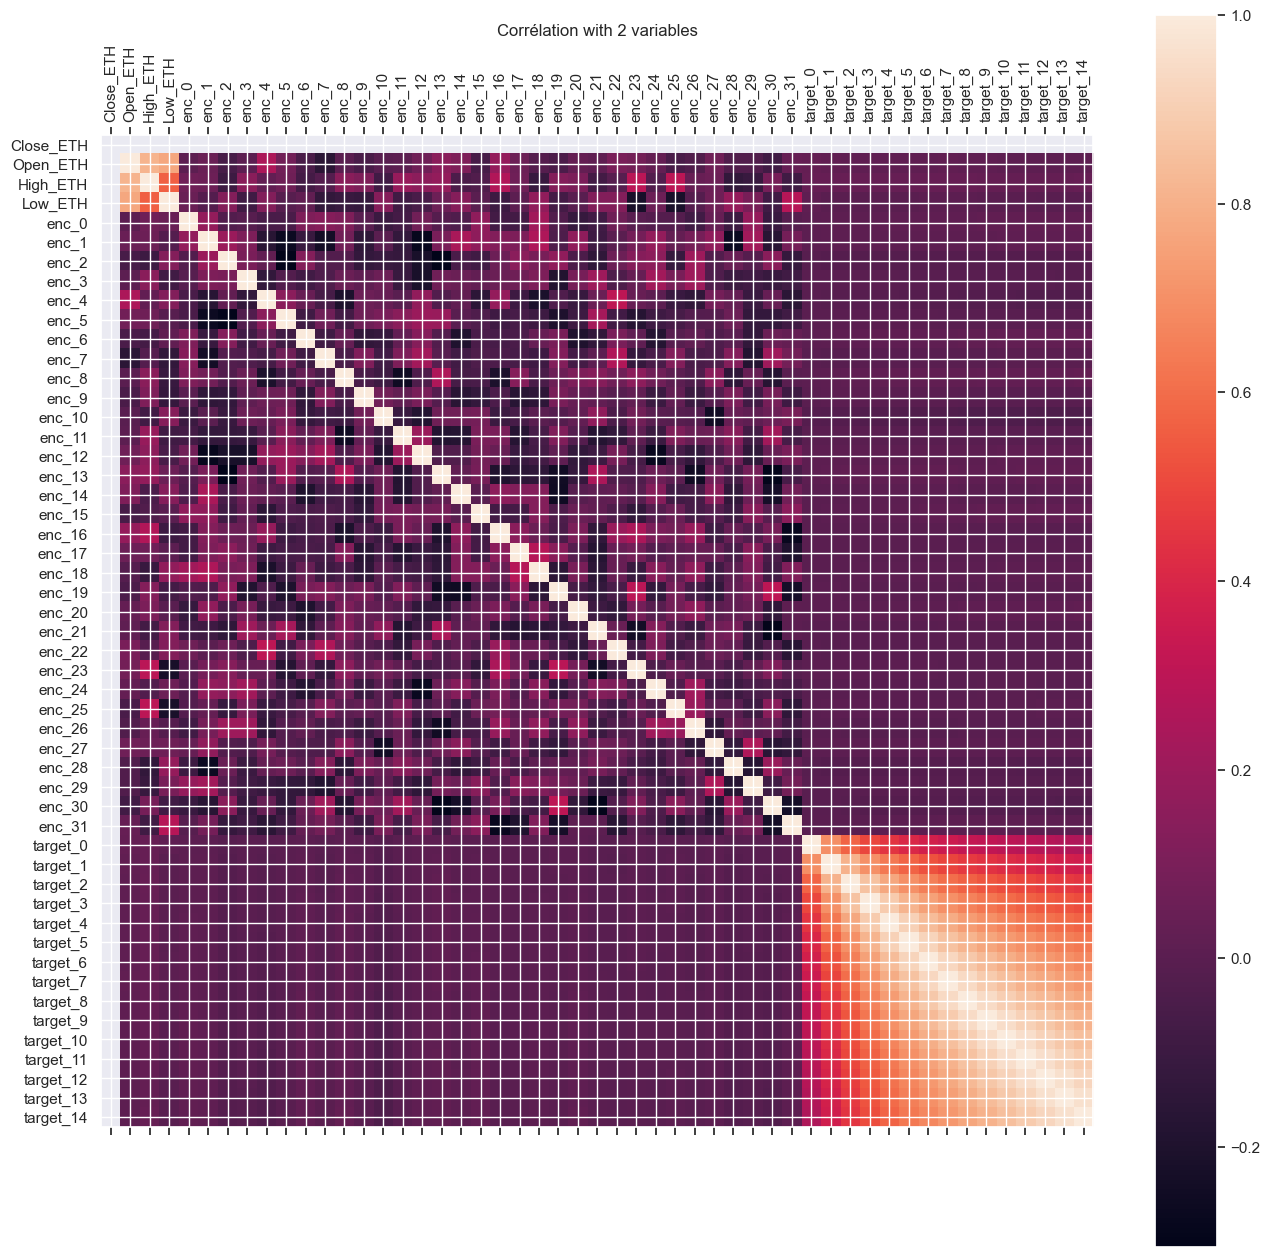

In [141]:
fig = plot_corr(corr_matrix_max) 

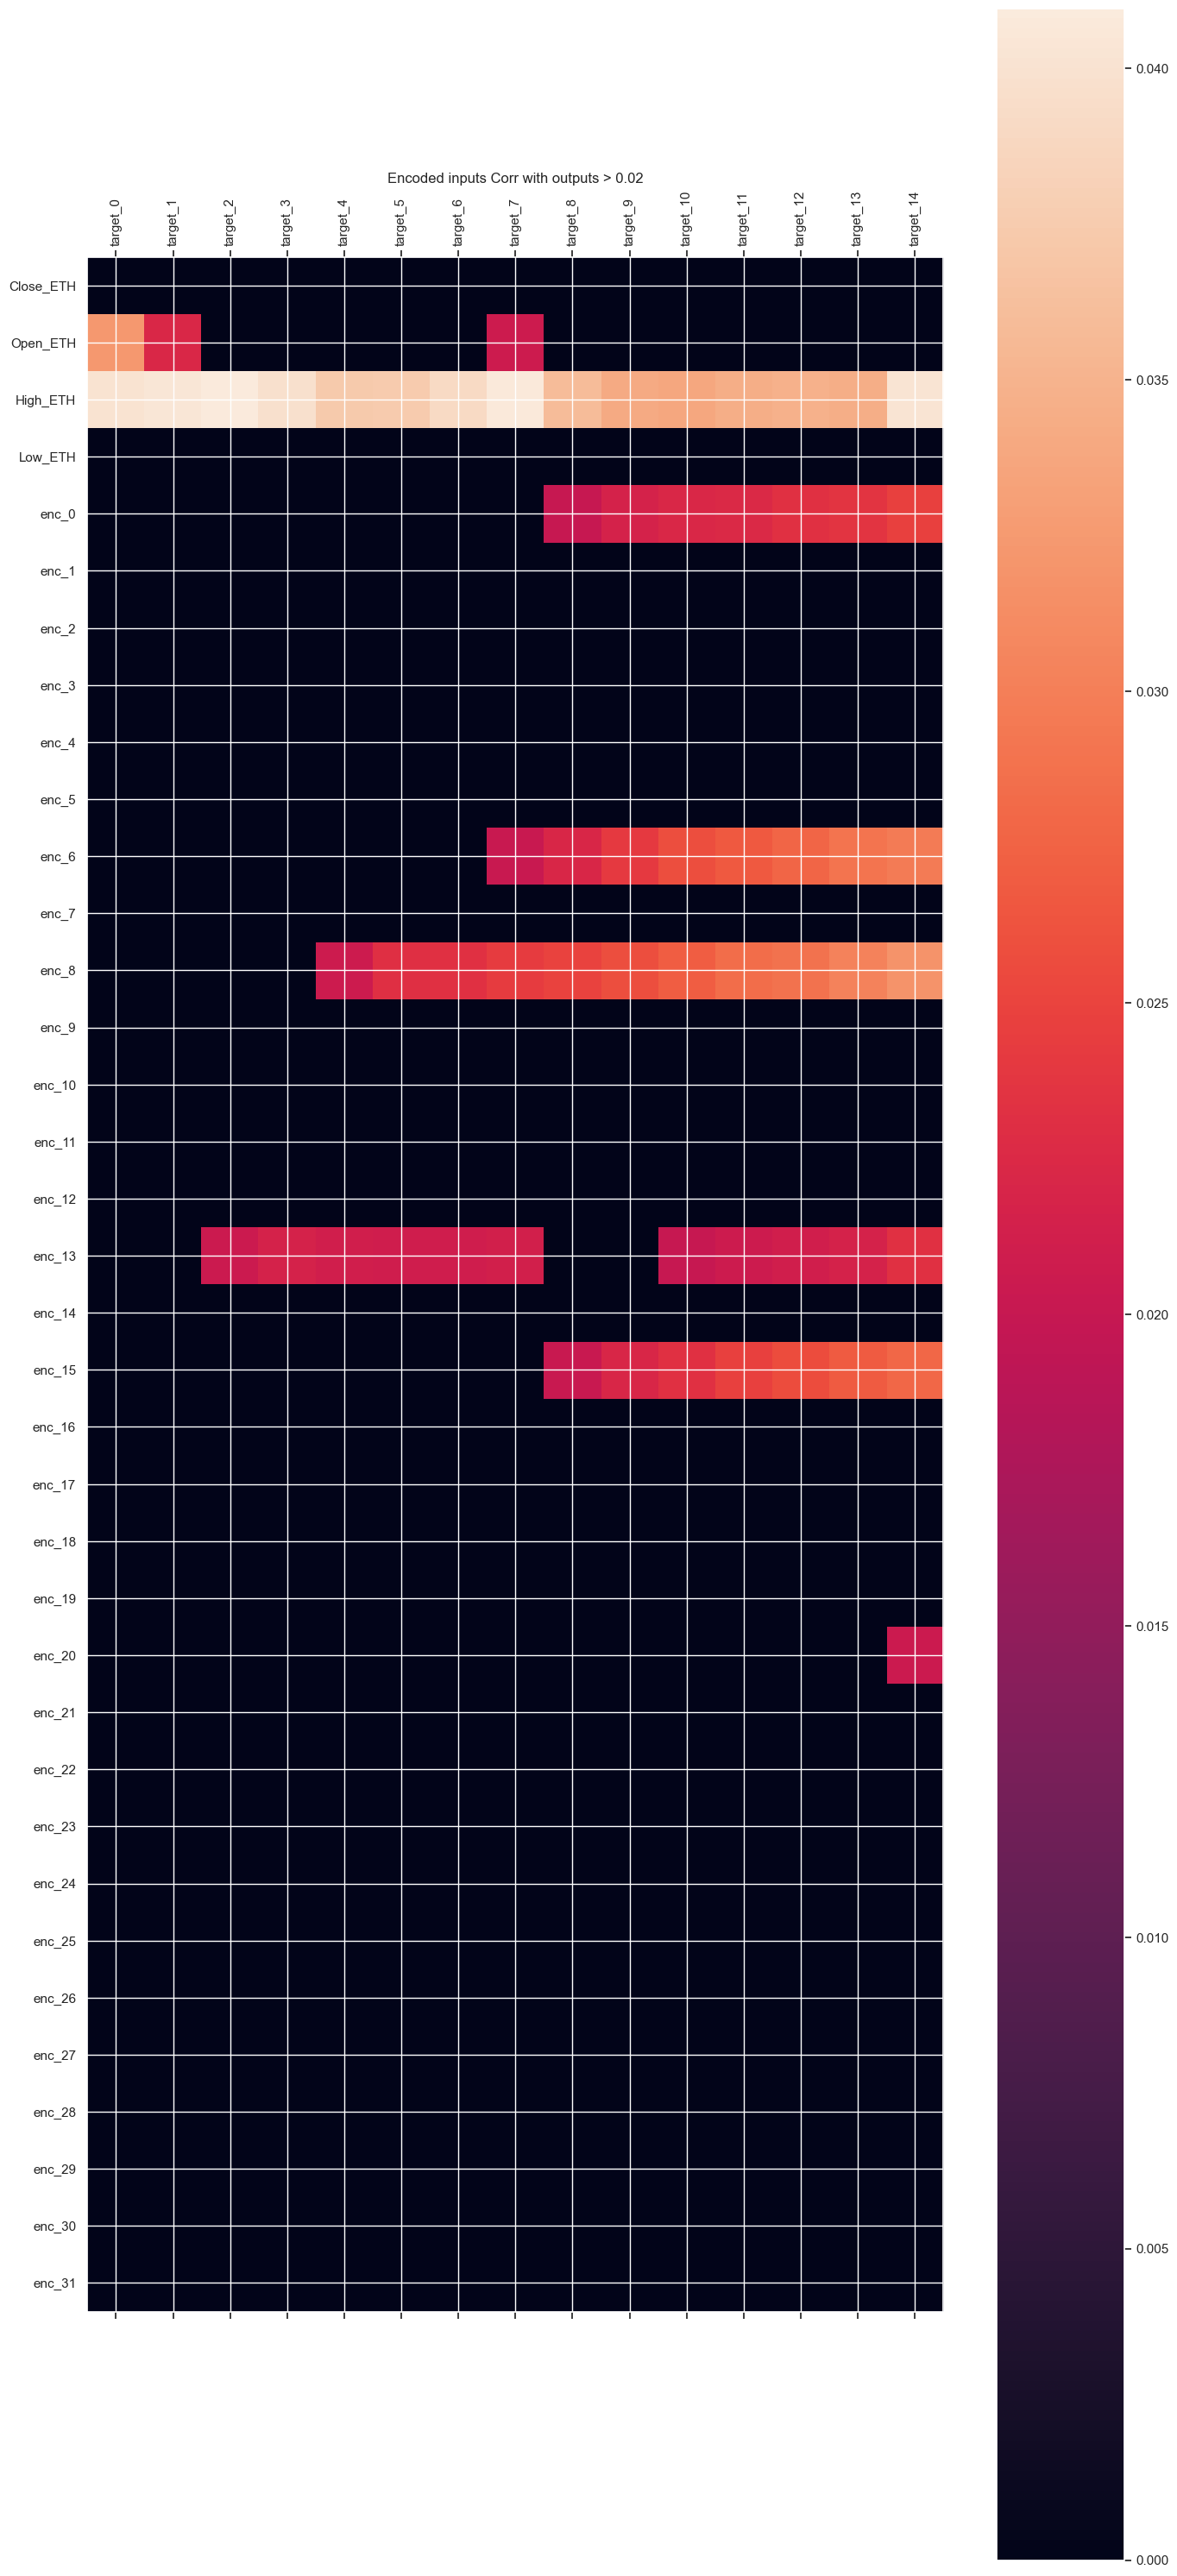

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

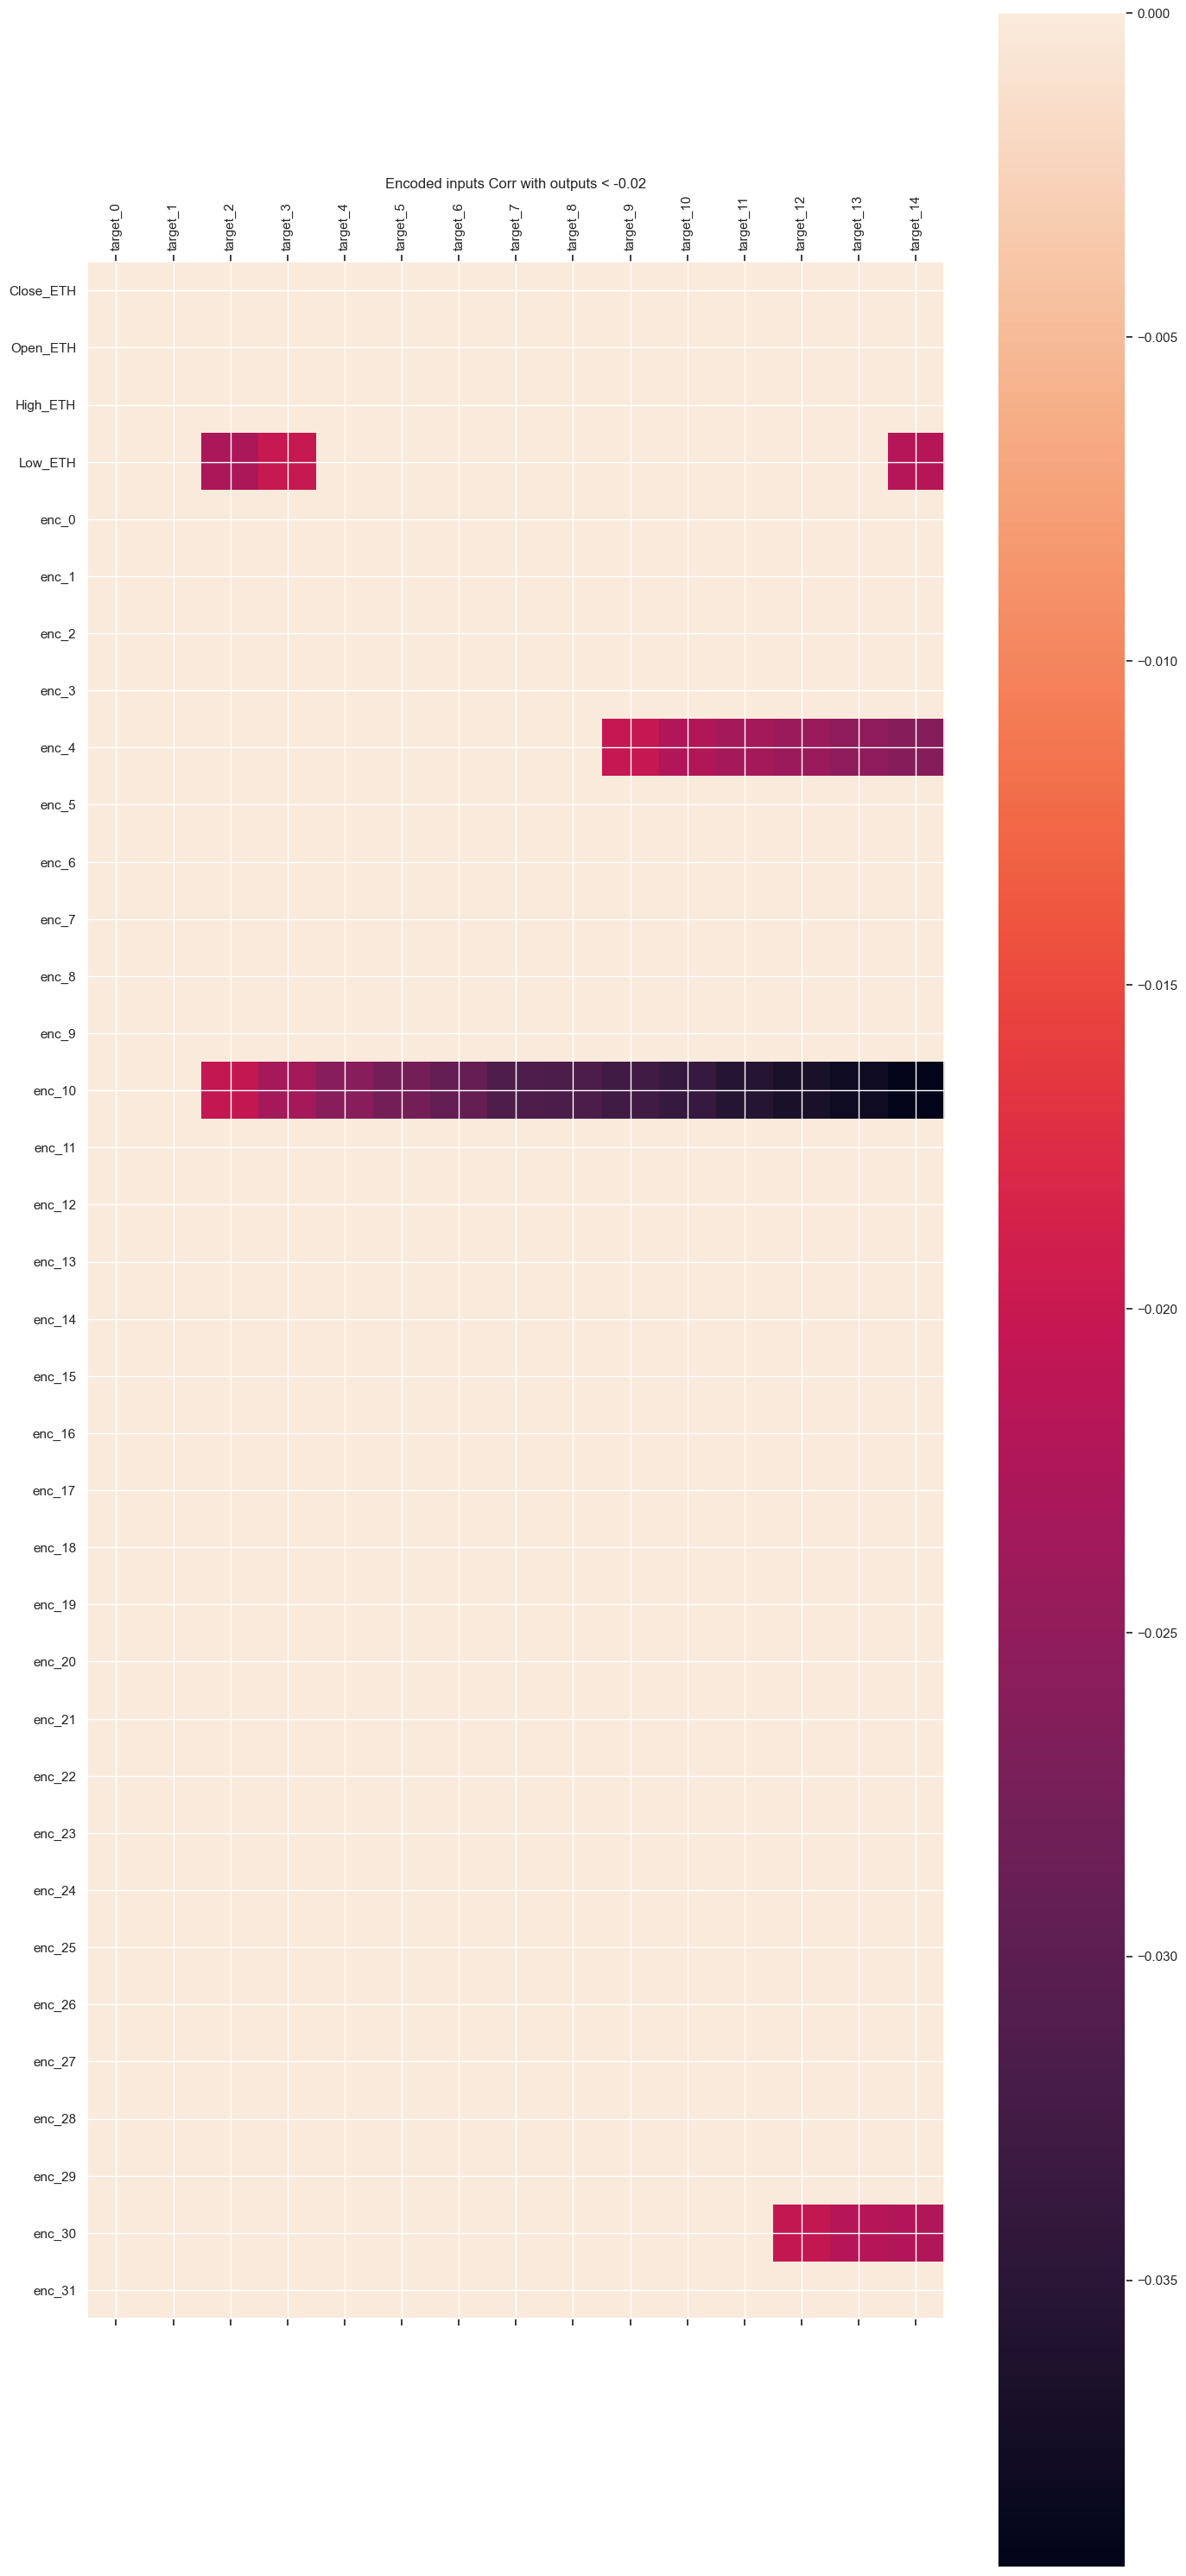

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
nb encoded features:  32


In [149]:
X_train_.shape

(99348, 72, 36)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(99348, 72, 36)

#### Train

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in LIST_UNITS_PRED: #[32, 64, 128]: #[128]: #
        for dropout_rate in  LIST_DROPOUT_PRED: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if PATIENCE_PRED is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=PATIENCE_PRED,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if PATIENCE_PRED == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if PATIENCE_PRED !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=512 / dropout= 0.3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1124352   
                                                                 
 layer_normalization (Layer  (None, 512)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 15)                7695      
                                                                 
Total params: 1133071 (4.32 MB)
Trainable params: 1133071 (4.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
No

In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=512 / dropout= 0.3


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [157]:
X_train_.shape

(99348, 72, 36)

##### Predict

In [158]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

13/13 [==============================] - 0s 17ms/step


##### Plots

In [159]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(99360,)
(99360,)


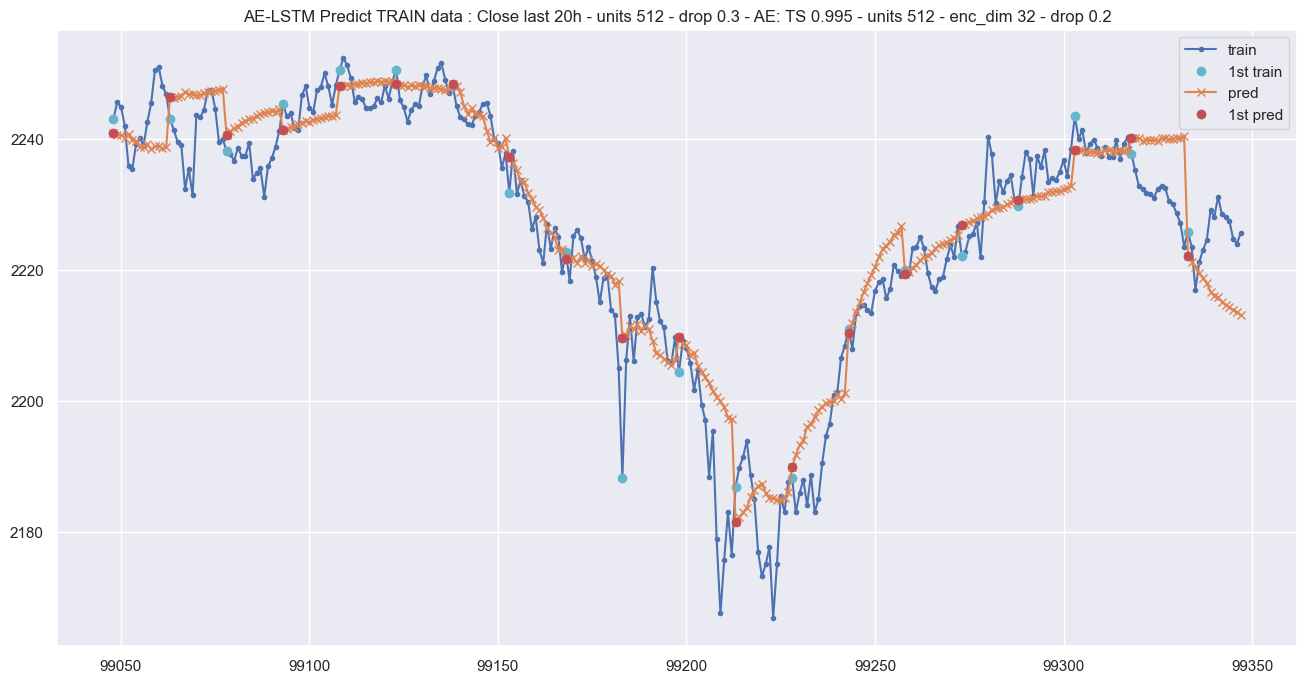

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

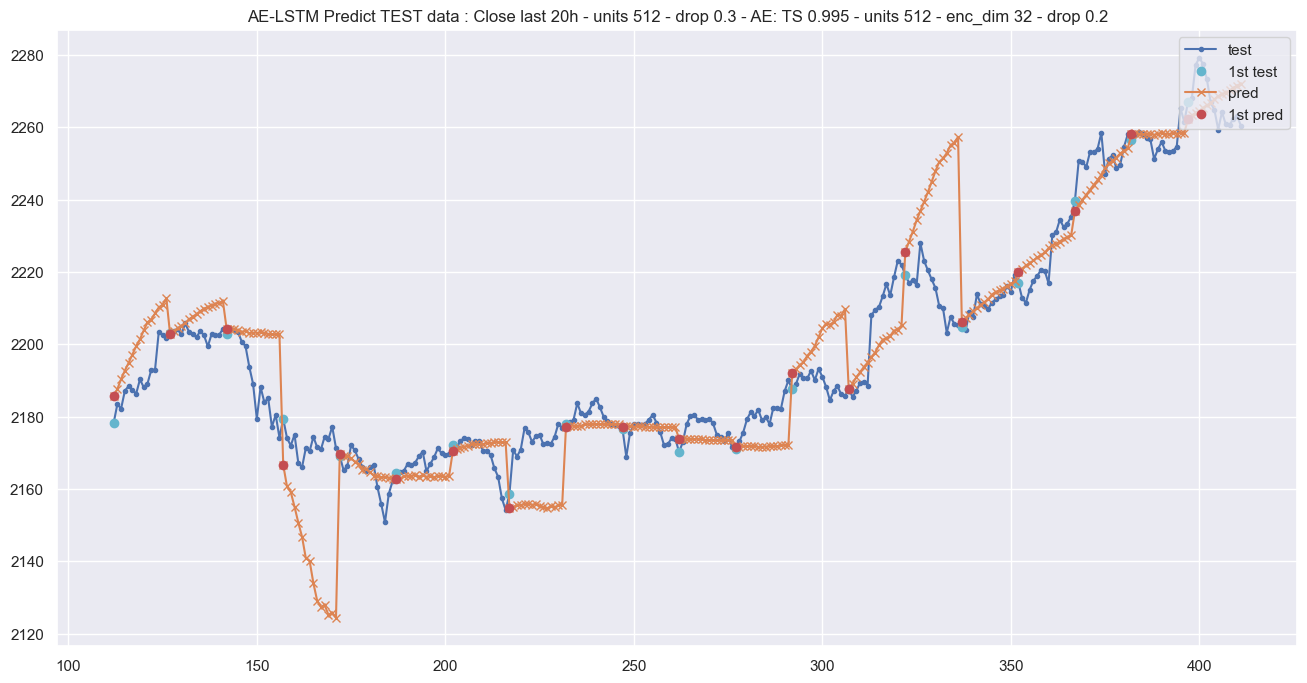

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

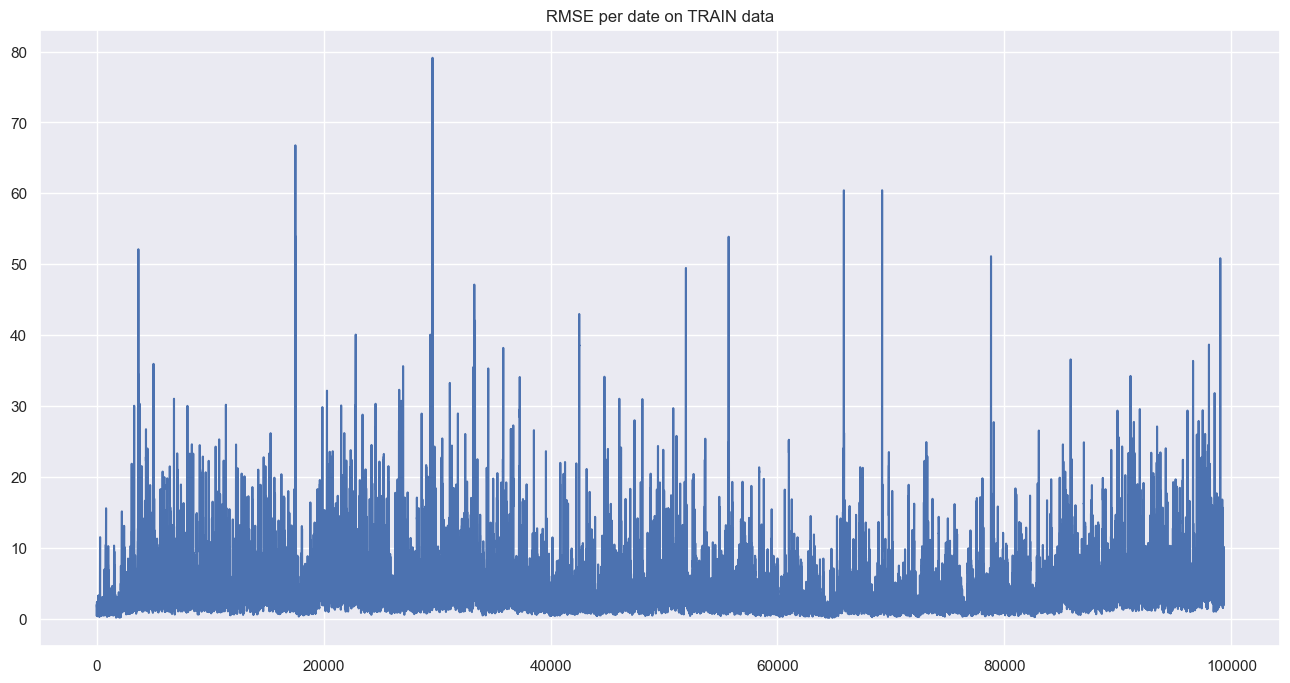

In [162]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

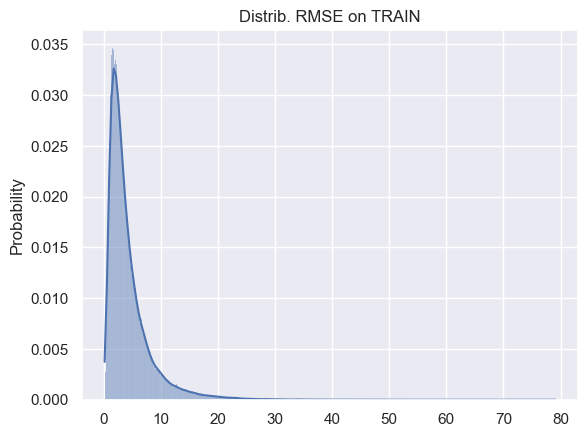

In [163]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.37')

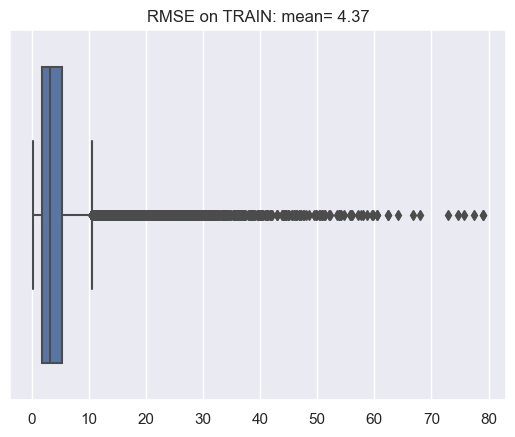

In [164]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

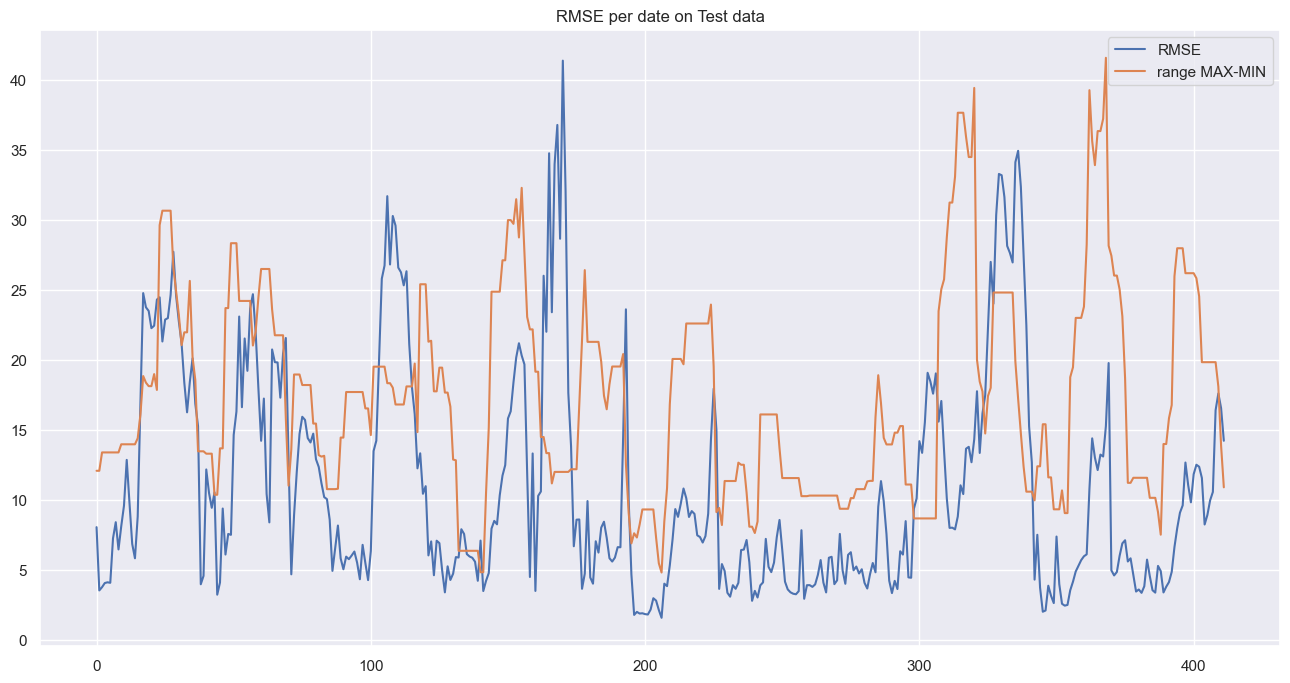

In [165]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [166]:
np.mean(arr_range)

17.382451456310662

<Axes: ylabel='Probability'>

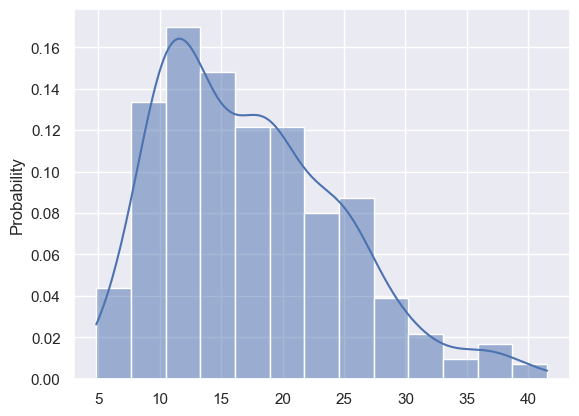

In [167]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [168]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

15.472885592521571

<Axes: ylabel='Probability'>

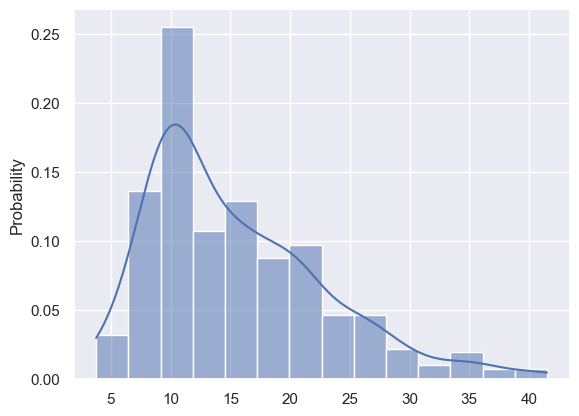

In [169]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

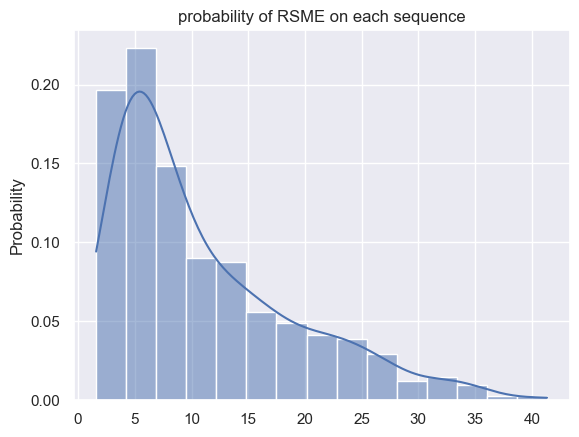

In [170]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 86.91225728155331)

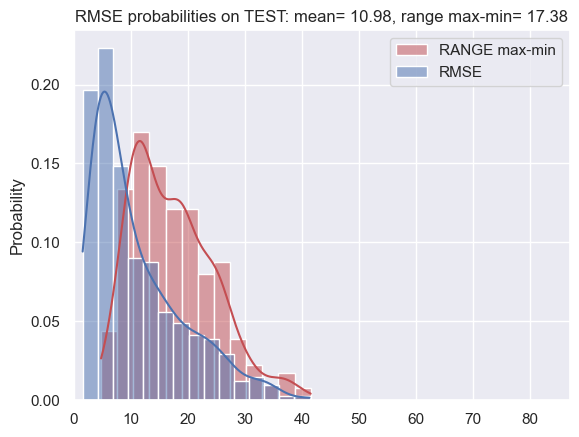

In [171]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 54.91938533499929)

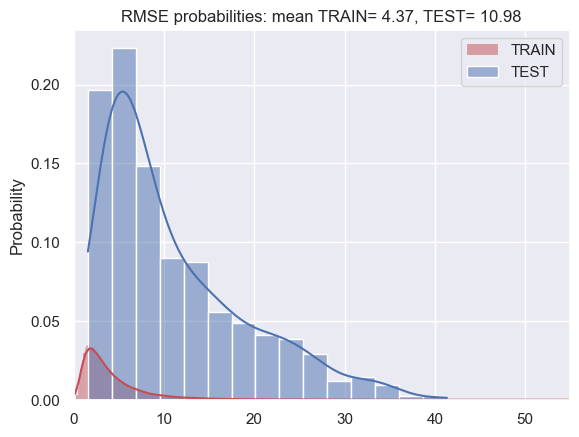

In [172]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 10.98')

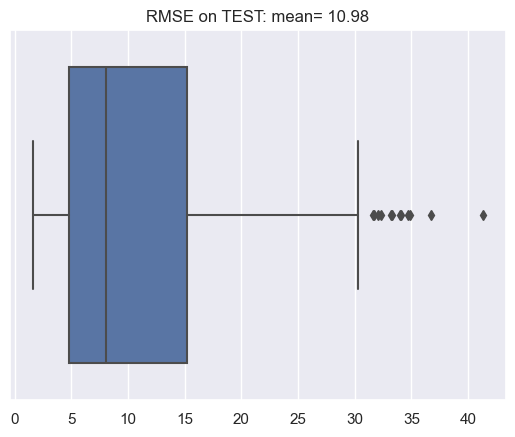

In [173]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [174]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[2277.46 2273.24 2266.85 2264.75 2259.37 2264.2  2260.82 2260.69 2262.27
 2263.15 2260.47 2259.48 2259.43 2263.28 2263.44]
[2279.73362236 2280.2639843  2280.00831289 2279.92544384 2280.16698675
 2280.3090868  2280.32104168 2280.9532918  2281.14674349 2280.72642078
 2280.98100538 2281.25651102 2281.27716036 2281.59586658 2281.67846394]


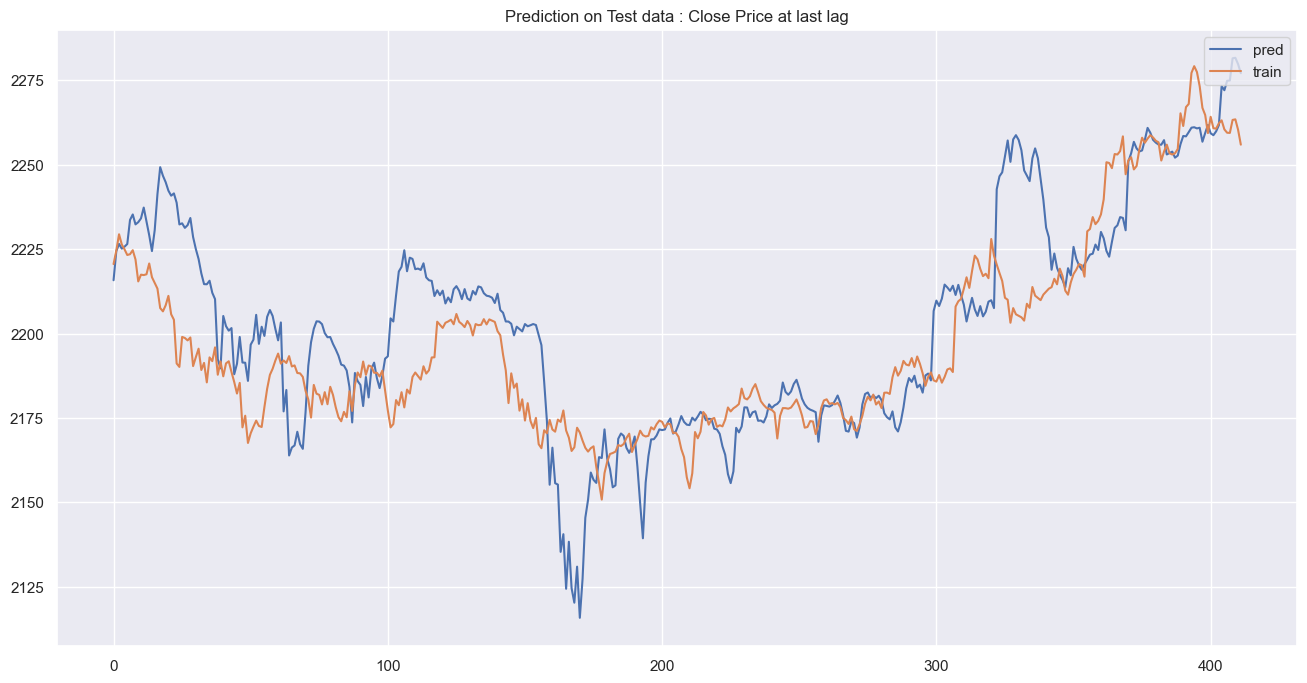

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

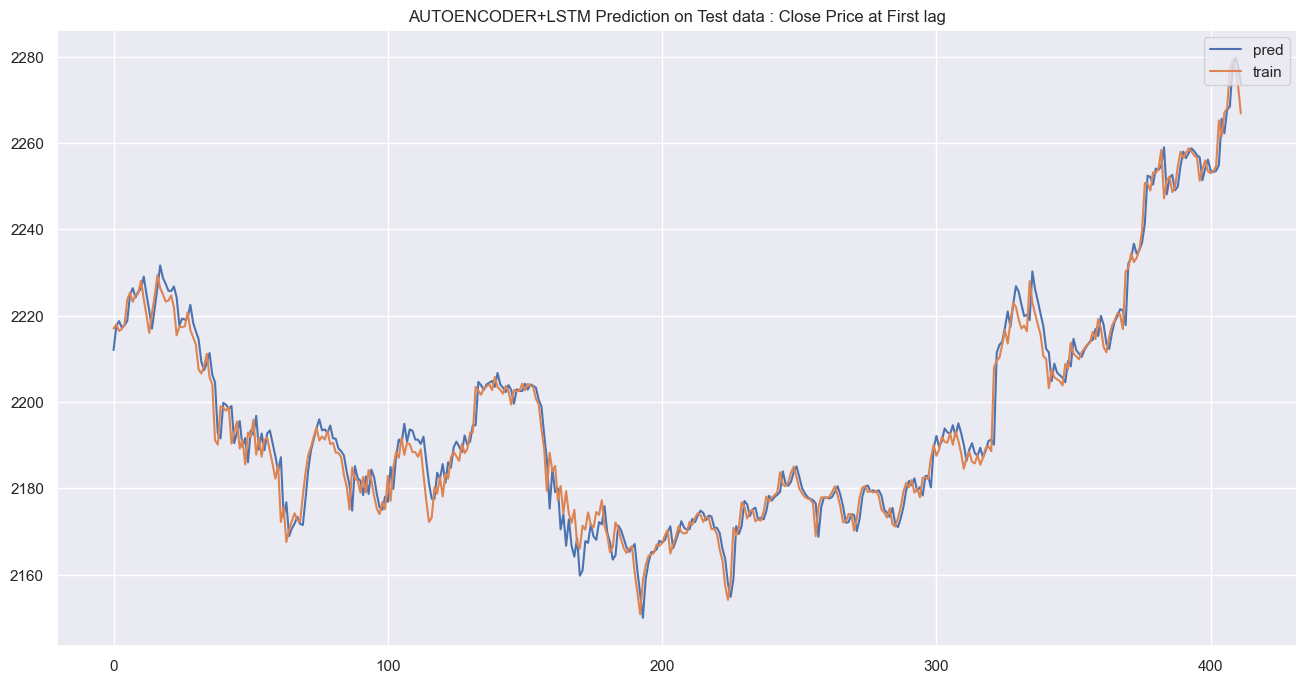

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

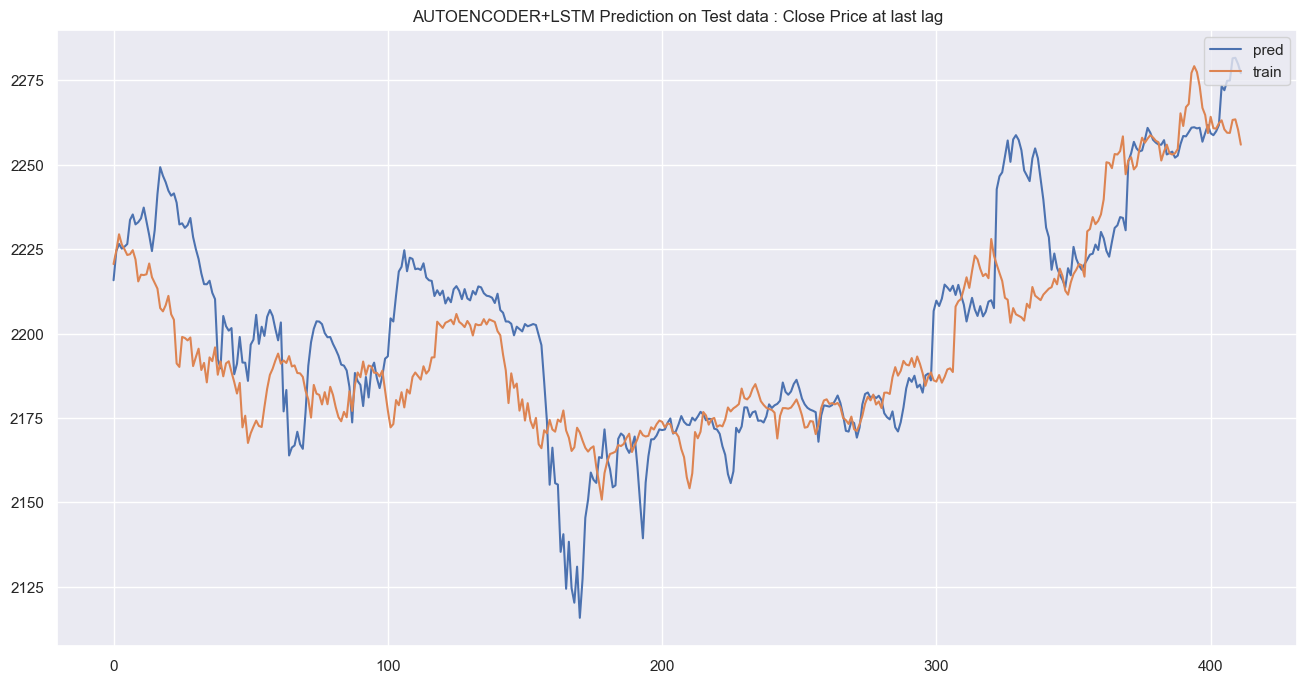

In [177]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [178]:
X_test_sca.shape

(412, 72, 102)

In [179]:
df_feat["Close_ETH"].iloc[-1]

2257.36

In [180]:
df_feat["Close_ETH"].iloc[-1]

2257.36

In [181]:
len(list_i_enc_select)

32

In [182]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[2213.28 2213.72 2216.21 2214.57 2219.21 2217.   2212.69 2211.5  2215.13
 2217.6  2218.9  2220.56 2220.23 2216.85 2230.26 2230.97 2234.49 2232.39
 2233.37 2235.29 2239.73 2250.74 2250.52 2248.99 2253.17 2253.03 2254.05
 2258.4  2247.18 2251.33 2252.23 2248.61 2249.63 2254.53 2258.   2256.51
 2257.72 2258.76 2258.07 2257.09 2256.64 2251.24 2253.91 2255.95 2253.42
 2253.02 2253.38 2254.67 2265.23 2261.47 2267.07 2268.01 2277.2  2279.2
 2277.46 2273.24 2266.85 2264.75 2259.37 2264.2  2260.82 2260.69 2262.27
 2263.15 2260.47 2259.48 2259.43 2263.28 2263.44 2260.35 2255.95 2257.36]
X_last[0,:,0] after divide by price:
[0.98047276 0.98066768 0.98177074 0.98104423 0.98309973 0.98212071
 0.9802114  0.97968423 0.98129231 0.9823865  0.9829624  0.98369777
 0.98355158 0.98205426 0.98799483 0.98830935 0.9898687  0.98893841
 0.98937254 0.99022309 0.99218999 0.99706737 0.99696991 0.99629213
 0.99814385 0.99808183 0.99853369 1.00046072 0.99549031 0.99732874
 0.99

In [183]:
X_last_encoded_sca.shape

(1, 72, 32)

In [184]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [185]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 32)

In [186]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [187]:
X_train_.shape

(99348, 72, 36)

In [188]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
99929  1702509900000   2259.44   2264.00  2259.43    2263.28    980.4476   
99930  1702510200000   2263.28   2264.53  2261.96    2263.44    769.0674   
99931  1702510500000   2263.43   2263.44  2259.24    2260.35    642.2866   
99932  1702510800000   2260.36   2260.67  2255.94    2255.95   1183.1841   
99933  1702511100000   2255.94   2257.37  2255.94    2257.36    208.2880   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1768.158184       1767.684879   
1      2023-01-01 00:05:00       1768.158184       1767.684879   
2      2023-01-01 00:10:00       1768.158184       1767.684879   
3      2023-01-01 00:15:00       1768.158184       1767.684879   
4      2023-01-01 00:20:00       1768.158184       1767.684879   
...                    ...               ...               ...   
99929  2023-12-13 23:25:00       2250.710000       2232.585000   
99930  2023-12-13 23:30:00       2250.670000       2232.810000   
99931  2023-12-13 23:35:00       2251.205000       2232.810000   
99932  2023-12-13 23:40:00       2251.205000       2234.405000   
99933  2023-12-13 23:45:00       2251.745000       2234.555000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
99929        2266.745  ...         NaN            NaN           NaN   
99930        2267.580  ...         NaN            NaN           NaN   
99931        2267.580  ...         NaN            NaN           NaN   
99932        2267.580  ...         NaN            NaN           NaN   
99933        2268.080  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
99929               NaN         0.0               NaN         0.0      0.0   
99930               NaN         0.0               NaN         0.0      0.0   
99931               NaN         0.0               NaN         0.0      0.0   
99932               NaN         0.0               NaN         0.0      0.0   
99933               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
99929                  NaN  False  
99930                  NaN  False  
99931                  NaN  False  
99932                  NaN  False  
99933                  NaN  False  

[99934 rows x 136 columns]

In [189]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [190]:
y_last_pred_unscaled

array([[0.99997675, 1.0001208 , 1.0003159 , 1.0003698 , 1.0005805 ,
        1.0006024 , 1.0005432 , 1.0007327 , 1.001078  , 1.0011894 ,
        1.0012456 , 1.0013585 , 1.001524  , 1.0016532 , 1.0017536 ]],
      dtype=float32)

In [191]:
df_feat["Close_ETH"].iloc[-1]

2257.36

In [192]:
y_last_pred_raw

array([[2257.3076, 2257.6328, 2258.0732, 2258.1948, 2258.6707, 2258.72  ,
        2258.5864, 2259.014 , 2259.7935, 2260.045 , 2260.1719, 2260.4268,
        2260.8003, 2261.092 , 2261.3186]], dtype=float32)

In [193]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [194]:
list_pred

[2258.1948,
 2258.6707,
 2258.72,
 2258.5864,
 2259.014,
 2259.7935,
 2260.045,
 2260.1719,
 2260.4268,
 2260.8003,
 2261.092,
 2261.3186]

In [195]:
save_list(list_pred, path_save_pred_vals)

In [196]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [197]:
list_pred_reload

[2258.1948,
 2258.6707,
 2258.72,
 2258.5864,
 2259.014,
 2259.7935,
 2260.045,
 2260.1719,
 2260.4268,
 2260.8003,
 2261.092,
 2261.3186]